In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import linregress, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf

import geopandas as gpd
import networkx as nx
import math

In [3]:

def scaling_iloc(x0,y0,name):
    # print(len(x0))
    samis = Get_SAMIs(x0,y0)
    # print("SAMIs = ",samis)
    # print("Var = ",np.round(np.var(samis),2))
    x = np.log(x0)
    Y = np.log(y0)
    X = sm.add_constant(x)
    model = sm.OLS(Y,X)
    fit = model.fit(cov_type='HC1')
    # print(fit.summary())
        
    intercept, slope = fit.params
    # print("intercept = ", np.round(intercept,2))
    # print("c = ", np.round(np.exp(intercept),3))

    x_0 =  np.sort(x0)[0]
    y_0 = np.exp(slope*np.log(x_0)+intercept)

    x_f = np.sort(x0)[-1]
    y_f = np.exp(slope*np.log(x_f)+intercept)
    y_null = np.exp(np.log(x_f)+intercept)

    beta = round(slope,3)
    R2 = str(round(fit.rsquared,2))
    # print(R2)
    # R2 = str(round(fit.pvalues[1],3))
    beta_lowerbound, beta_upper = fit.conf_int().iloc[1]
    beta_lowerbound = np.round(beta_lowerbound,2)
    beta_upper = np.round(beta_upper,2)
    return fit.conf_int().iloc[1,:],samis,beta,float(R2)

def Get_SAMIs(x0,y0):
    x = np.log(x0)
    y = np.log(y0)
    res = linregress(x,y)
    y_hat = res.intercept + res.slope*x
    SAMIs = y-y_hat
    return SAMIs


def all_upper(my_list): 
    return list(map(lambda x: x.upper(), my_list))

def getGini( percapita):

    mad = np.abs(np.subtract.outer(percapita, percapita)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(percapita)
    # Gini coefficient
    G = 0.5 * rmad
    # print(G)
    return G

def scaling_weighted(x0,y0,name):
    # print(len(x0))
    samis = Get_SAMIs(x0,y0)
    # print("SAMIs = ",samis)
    # print("Var = ",np.round(np.var(samis),2))
    x = np.log(x0)
    Y = np.log(y0)
    
    errors = Y - np.mean(Y)
    error_variance = np.var(errors)
    weights = 1/error_variance

    X = sm.add_constant(x)
    model = sm.WLS(Y,X, weights=error_variance)
    fit = model.fit(cov_type='HC1')
    # print(fit.summary())
        
    intercept, slope = fit.params
    # print("intercept = ", np.round(intercept,2))
    # print("c = ", np.round(np.exp(intercept),3))

    x_0 =  np.sort(x0)[0]
    y_0 = np.exp(slope*np.log(x_0)+intercept)

    x_f = np.sort(x0)[-1]
    y_f = np.exp(slope*np.log(x_f)+intercept)
    y_null = np.exp(np.log(x_f)+intercept)

    betta = round(slope,3)
    R2 = str(round(fit.rsquared,2))
    # print(R2)
    # R2 = str(round(fit.pvalues[1],3))
    beta_lowerbound, beta_upper = fit.conf_int().iloc[1]
    beta_lowerbound = np.round(beta_lowerbound,2)
    beta_upper = np.round(beta_upper,2)


    return fit.conf_int().iloc[1,:],samis,betta,float(R2)


def Compute_Gini(Y):
    T_plus = np.sum(Y[Y>0])
    T_minus = -np.sum(Y[Y<0])
    delta = 0
    N = len(Y)
    for i in range(N):
        for j in range(N):
            delta += np.abs(Y.iloc[i]-Y.iloc[j])
    delta = delta/(2*N**2)
    mu_p = ((N-1)/N**2)*(T_plus+T_minus)
    return delta/mu_p

In [4]:
groupedict = { 
               "DERMATOLOGY":['MICROGRAPHIC DERMATOLOGIC SURGERY (MDS)'],
               "EMERGENCY MEDICINE":[
                                    'SPORTS MEDICINE',
                                    # 'PAIN MANAGEMENT',
                                    'HOSPICE/PALLIATIVE CARE',
                                    'CRITICAL CARE (INTENSIVISTS)',

                                    'PHYSICIAN ASSISTANT'],
               "FAMILY PRACTICE":[
                                  'SPORTS MEDICINE',
                                  # 'PAIN MANAGEMENT',
                                  'SLEEP MEDICINE',
                                  'HOSPICE/PALLIATIVE CARE',
                                  'GERIATRIC MEDICINE',
                                  'PHYSICIAN ASSISTANT', 
                                #   'GENERAL PRACTICE',
                                  'CERTIFIED CLINICAL NURSE SPECIALIST (CNS)',
                                  ],

               "NURSE PRACTITIONER":[
                                  'CERTIFIED CLINICAL NURSE SPECIALIST (CNS)',
                                  'CERTIFIED NURSE MIDWIFE (CNM)',
                                  'CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)',

                   
                                  ],
               "INTERNAL MEDICINE":[
                                    'SPORTS MEDICINE',
                                    'SLEEP MEDICINE',
                                    'RHEUMATOLOGY',
                                    'PULMONARY DISEASE',
                                    'NEPHROLOGY',
                                    'MEDICAL ONCOLOGY',
                                    'HEMATOLOGY',
                                    'HOSPICE/PALLIATIVE CARE', 
                                    'GASTROENTEROLOGY', 
                                    'GERIATRIC MEDICINE',
                                    'ENDOCRINOLOGY',
                                    'CRITICAL CARE (INTENSIVISTS)',
                                    'CARDIOVASCULAR DISEASE (CARDIOLOGY)', 
                                    'CARDIAC ELECTROPHYSIOLOGY',
                                    'INTERVENTIONAL CARDIOLOGY',
                                    'INFECTIOUS DISEASE',
                                    'ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY',
                                    ],
               
               "OBSTETRICS/GYNECOLOGY":[
                                    'CRITICAL CARE (INTENSIVISTS)',
                                    'GYNECOLOGICAL ONCOLOGY',
                                    'ENDOCRINOLOGY',
                                    'CERTIFIED NURSE MIDWIFE (CNM)',
                                    'HOSPICE/PALLIATIVE CARE',
                                    ],
               "MEDICAL ONCOLOGY":['GYNECOLOGICAL ONCOLOGY','SURGICAL ONCOLOGY', 'HEMATOLOGY/ONCOLOGY'],
               "OPHTHALMOLOGY":[
                                    # 'OPTOMETRY'
                                    ],
               'OPTOMETRY':[],
               "ORTHOPEDIC SURGERY":[
                                    'HAND SURGERY',
                                    'PODIATRY',
                                    'SPORTS MEDICINE',
                                    
                                    ],
               "OTOLARYNGOLOGY":[
                                    "MAXILLOFACIAL SURGERY", 
                                    "ORAL SURGERY",
                                    "QUALIFIED AUDIOLOGIST",
                                    "SLEEP MEDICINE",
                                    "PLASTIC AND RECONSTRUCTIVE SURGERY",
                                    ],
               "PATHOLOGY":[
                                    "QUALIFIED SPEECH LANGUAGE PATHOLOGIST",
                                    "HEMATOLOGY",
                                    ],
               "PEDIATRIC MEDICINE":[
                                    "SLEEP MEDICINE",
                                    "SPORTS MEDICINE",
               ],
               "PHYSICAL MEDICINE AND REHABILITATION":[
                                    "PHYSICAL THERAPY",
                                    'HOSPICE/PALLIATIVE CARE',
                                    "OCCUPATIONAL THERAPY", 
                                    "PAIN MANAGEMENT",
                                    "SPORTS MEDICINE",
                                    ],
               "PAIN MANAGEMENT":['INTERVENTIONAL PAIN MANAGEMENT'],
               "PLASTIC AND RECONSTRUCTIVE SURGERY":["HAND SURGERY"],
               "PREVENTIVE MEDICINE":["ADDICTION MEDICINE"],
               "PSYCHIATRY":[
                                    "CLINICAL PSYCHOLOGIST",
                                    "PAIN MANAGEMENT",
                                    "SLEEP MEDICINE",
                                    ],
               "NEUROLOGY":[        
                                    "NEUROSURGERY",
                                    "CLINICAL PSYCHOLOGIST",
                                    "PAIN MANAGEMENT",
                                    "SLEEP MEDICINE",
                                    ],
               "GENERAL PRACTICE":["VASCULAR SURGERY",
                                   "GENERAL SURGERY", 
                                   "SURGICAL ONCOLOGY"],
               "GENERAL SURGERY":[
                                  "HAND SURGERY",
                                  "SURGICAL ONCOLOGY",
                                  "COLORECTAL SURGERY (PROCTOLOGY)",
                                  "VASCULAR SURGERY",
                                  'CARDIAC SURGERY',
                                  'PLASTIC AND RECONSTRUCTIVE SURGERY',
                                  'THORACIC SURGERY',
                                  ],
               "VASCULAR SURGERY":["HAND SURGERY",
                                  "SURGICAL ONCOLOGY"],
               "INTERVENTIONAL RADIOLOGY":[
                                    "NUCLEAR MEDICINE",
                                    "PAIN MANAGEMENT"], 
               "DIAGNOSTIC RADIOLOGY":[
                                    "NUCLEAR MEDICINE",
                                    "PAIN MANAGEMENT",
                                    "INTERVENTIONAL RADIOLOGY",
                                    
               ], 
               "RADIATION ONCOLOGY":[
                                    # "PAIN MANAGEMENT",
                                    'HOSPICE/PALLIATIVE CARE',
               ],

               "ANESTHESIOLOGY":["ANESTHESIOLOGY ASSISTANT", 
                                 "CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)",
                                 'CRITICAL CARE (INTENSIVISTS)',
                                 'PAIN MANAGEMENT',
                                 "SLEEP MEDICINE", 
                                 "HOSPICE/PALLIATIVE CARE"],
               "ALLERGY/IMMUNOLOGY":["REGISTERED DIETITIAN OR NUTRITION PROFESSIONAL"],
            #    "SPORTS MEDICINE":["PHYSICAL THERAPY"],
               "SPORTS MEDICINE":[],
               'CARDIOVASCULAR DISEASE (CARDIOLOGY)':['CARDIAC ELECTROPHYSIOLOGY','CARDIAC SURGERY','INTERVENTIONAL CARDIOLOGY'],
               'HEMATOLOGY':['HEMATOLOGY/ONCOLOGY'],
               "OCCUPATIONAL THERAPY":["CHIROPRACTIC","OSTEOPATHIC MANIPULATIVE MEDICINE"],
               "CLINICAL PSYCHOLOGIST":["MARRIAGE AND FAMILY THERAPIST","MENTAL HEALTH COUNSELOR","CLINICAL SOCIAL WORKER"],
               
               'CARDIAC SURGERY':['ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY'],
               'PODIATRY':["PHYSICAL MEDICINE AND REHABILITATION"],
               "THORACIC SURGERY":['CARDIAC SURGERY'],
               "UROLOGY":[],
               "COLORECTAL SURGERY (PROCTOLOGY)":[],
               'NUCLEAR MEDICINE':[],
               }

### Hierarchical network measure

In [5]:


G = nx.DiGraph()

for node, neighbors in groupedict.items():
    G.add_node(node)
    for n in neighbors:
        G.add_node(n)
        G.add_edge(node, n)

CE_positive = np.zeros((len(G.nodes), len(G.nodes)), dtype=float)
CE_negative = np.zeros((len(G.nodes), len(G.nodes)), dtype=float)

D_out = np.zeros((len(G.nodes), len(G.nodes)), dtype=float)

for i in range(len(G.nodes())):
    for j in range(len(G.nodes())):
        src = list(G.nodes())[i]
        tgt = list(G.nodes())[j]
        if src != tgt:
            Eij_positive = np.sum([math.prod([1/G.in_degree(v) for v in p[1:]]) for p in nx.all_simple_paths(G, src, tgt)])
            dij = [1/((len(p)-1)) for p in nx.all_simple_paths(G, src, tgt)]
            D_out[i,j] = np.sum(dij)
            Eij_negative = np.sum([math.prod([1/G.out_degree(v) for v in p[:-1]]) for p in nx.all_simple_paths(G, tgt, src)])
            
            # print(Eij_positive, Eij_negative)
            CE_positive[i,j] = Eij_positive
            CE_negative[i,j] = Eij_negative

eta = np.sum(CE_positive-CE_negative, axis=1)
mu = np.sum(CE_positive-CE_negative, axis=0)

            

df_analysis = pd.DataFrame({
    'Specialty': nx.pagerank(G).keys(),
    'PageRank': nx.pagerank(G).values(),
    'katz_centrality': nx.katz_centrality(G).values(),
    'in_degree_centrality': nx.in_degree_centrality(G).values(),
    'out_degree_centrality': nx.out_degree_centrality(G).values(),
    'local_reaching_centrality': [nx.local_reaching_centrality(G, v) for v in G.nodes()],
    # 'global_reaching_centrality': nx.global_reaching_centrality(G).values(),
})

df_analysis['breadth_score'] = eta
df_analysis['depth_score'] = mu

df_analysis['CE_positive'] = np.sum(CE_positive, axis=1)
df_analysis['CE_negative'] = np.sum(CE_negative, axis=1)

df_analysis['new_reaching'] = np.sum(D_out, axis=1)/(len(G.nodes)-1)
# df_analysis = df.merge(df_analysis, on='Specialty')
df_analysis


Specialty  PageRank  katz_centrality  \
0                               DERMATOLOGY  0.009207         0.099984   
1   MICROGRAPHIC DERMATOLOGIC SURGERY (MDS)  0.017033         0.109982   
2                        EMERGENCY MEDICINE  0.009207         0.099984   
3                           SPORTS MEDICINE  0.022722         0.161074   
4                   HOSPICE/PALLIATIVE CARE  0.026896         0.171072   
..                                      ...       ...              ...   
70        OSTEOPATHIC MANIPULATIVE MEDICINE  0.014511         0.111092   
71            MARRIAGE AND FAMILY THERAPIST  0.013109         0.111982   
72                  MENTAL HEALTH COUNSELOR  0.013109         0.111982   
73                   CLINICAL SOCIAL WORKER  0.013109         0.111982   
74                                  UROLOGY  0.009207         0.099984   

    in_degree_centrality  out_degree_centrality  local_reaching_centrality  \
0               0.000000               0.013514                   0.013514   
1               0.013514               0.000000                   0.000000   
2               0.000000               0.054054                   0.054054   
3               0.081081               0.000000                   0.000000   
4               0.094595               0.000000                   0.000000   
..                   ...                    ...                        ...   
70              0.013514               0.000000                   0.000000   
71              0.013514               0.000000                   0.000000   
72              0.013514               0.000000                   0.000000   
73              0.013514               0.000000                   0.000000   
74              0.000000               0.000000                   0.000000   

    breadth_score  depth_score  CE_positive  CE_negative  new_reaching  
0        1.000000    -1.000000     1.000000     0.000000      0.013514  
1       -1.000000     1.000000     0.000000     1.000000      0.000000  
2        1.059524    -1.000000     1.059524     0.000000      0.054054  
3       -1.775490     1.333333     0.000000     1.775490      0.000000  
4       -2.308824     1.285714     0.000000     2.308824      0.000000  
..            ...          ...          ...          ...           ...  
70      -0.733333     4.000000     0.000000     0.733333      0.000000  
71      -0.527778     2.000000     0.000000     0.527778      0.000000  
72      -0.527778     2.000000     0.000000     0.527778      0.000000  
73      -0.527778     2.000000     0.000000     0.527778      0.000000  
74       0.000000     0.000000     0.000000     0.000000      0.000000  

[75 rows x 11 columns]

### visualization of medical intra-specialty network

In [6]:
links = []

for specialty, subspecialties in groupedict.items():
    for subspecialty in subspecialties:
        links.append({"source": specialty, "target": subspecialty, "value": 1})


nodes = list(set([link["source"] for link in links] + [link["target"] for link in links]))

node_map = {node: idx for idx, node in enumerate(nodes)}

sankey_links = {
    "source": [node_map[link["source"]] for link in links],
    "target": [node_map[link["target"]] for link in links],
    "value": [link["value"] for link in links],
}


fig = go.Figure(
    go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes,
            color=["skyblue" if node in specialty else "lightblue" for node in nodes],
        ),
        link=sankey_links,
    )
)

fig.update_layout(
    #title_text="Specialties and Subspecialties - Sankey Diagram",
    font_size=10,
    width = 1000,
    height=1000,  # Increase height for larger datasets
)
# fig.savefig('doctorNetwork.pdf', dpi=300)
fig.show()


In [7]:
CountBySpecialty = pd.read_csv('./CountBySpecialty.csv')
CountBySpecialty['PerCapita'] = CountBySpecialty['Count']/CountBySpecialty['msa_pop']
CountBySpecialty.head()

Unnamed: 0     cbsa      msa_name  msa_pop                           LSAD  \
0           0  10100.0  Aberdeen, SD    41790  Micropolitan Statistical Area   
1           1  10140.0  Aberdeen, WA    77290  Micropolitan Statistical Area   
2           2  10180.0   Abilene, TX   181591  Metropolitan Statistical Area   
3           3  10220.0       Ada, OK    38396  Micropolitan Statistical Area   
4           4  10300.0    Adrian, MI    97520  Micropolitan Statistical Area   

   Specialty  Count  PerCapita  
0  PATHOLOGY      2   0.000048  
1  PATHOLOGY      2   0.000026  
2  PATHOLOGY      4   0.000022  
3  PATHOLOGY      2   0.000052  
4  PATHOLOGY     11   0.000113

In [8]:
cbsacode = CountBySpecialty.cbsa.unique()
Specialty = CountBySpecialty.Specialty.unique()
new_df = pd.DataFrame({
    'cbsacode':cbsacode,
    # 'Specialty':[],
    # 'Specialty_Count':[],
})
for s in Specialty:
    new_df[s] = np.nan

for c in cbsacode:
    for s in Specialty:
        try:
            sc = CountBySpecialty[(CountBySpecialty['cbsa']==c)&(CountBySpecialty['Specialty']==s)]['Count'].iloc[0]
            new_df.loc[new_df['cbsacode'] == c, s] = sc
        except:
            new_df.loc[new_df['cbsacode'] == c, s] = 0
            
new_df

cbsacode  PATHOLOGY  CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)  \
0     10100.0        2.0                                           27.0   
1     10140.0        2.0                                            1.0   
2     10180.0        4.0                                           77.0   
3     10220.0        2.0                                           11.0   
4     10300.0       11.0                                           31.0   
..        ...        ...                                            ...   
893   33740.0        0.0                                            0.0   
894   34300.0        0.0                                            0.0   
895   39700.0        0.0                                            0.0   
896   42900.0        0.0                                            0.0   
897   49820.0        0.0                                            0.0   

     GYNECOLOGICAL ONCOLOGY  EMERGENCY MEDICINE  HOSPITALIST  FAMILY PRACTICE  \
0                       0.0                 4.0          3.0             11.0   
1                       0.0                18.0          2.0             19.0   
2                       0.0                24.0          3.0             87.0   
3                       0.0                34.0          2.0             40.0   
4                       0.0                 3.0          1.0             20.0   
..                      ...                 ...          ...              ...   
893                     0.0                 0.0          0.0              1.0   
894                     0.0                 0.0          0.0              9.0   
895                     0.0                 0.0          0.0              5.0   
896                     0.0                 0.0          0.0              6.0   
897                     0.0                 0.0          0.0              1.0   

     OBSTETRICS/GYNECOLOGY  PHYSICIAN ASSISTANT  GENERAL PRACTICE  ...  \
0                      7.0                 24.0               0.0  ...   
1                      3.0                 13.0               0.0  ...   
2                     15.0                103.0               4.0  ...   
3                      9.0                 44.0               1.0  ...   
4                      4.0                 31.0               0.0  ...   
..                     ...                  ...               ...  ...   
893                    0.0                  1.0               0.0  ...   
894                    0.0                 20.0               0.0  ...   
895                    0.0                  4.0               0.0  ...   
896                    0.0                  8.0               0.0  ...   
897                    0.0                  0.0               0.0  ...   

     MEDICAL TOXICOLOGY  ADULT CONGENITAL HEART DISEASE (ACHD)  \
0                   0.0                                    0.0   
1                   0.0                                    0.0   
2                   0.0                                    0.0   
3                   0.0                                    0.0   
4                   0.0                                    0.0   
..                  ...                                    ...   
893                 0.0                                    0.0   
894                 0.0                                    0.0   
895                 0.0                                    0.0   
896                 0.0                                    0.0   
897                 0.0                                    0.0   

     UNDEFINED NON-PHYSICIAN TYPE (SPECIFY)  PERIPHERAL VASCULAR DISEASE  \
0                                       0.0                          0.0   
1                                       0.0                          0.0   
2                                       0.0                          0.0   
3                                       0.0                          0.0   
4                                       0.0                          

In [24]:
Specialty_Count_cbsa = pd.read_csv("./Specialty_Count_cbsa.csv")
df_name = pd.read_csv("./new_results_all.csv")
Specialty_Count_cbsa['DN'] = Specialty_Count_cbsa.iloc[:, 100:].sum(axis=1)
Dmax = Specialty_Count_cbsa['DN'].max()

M = len(Specialty_Count_cbsa)
Cities = []
Ns = []
f_dfs = []
x_dfs = []
for i in range(M):
    N = Specialty_Count_cbsa.iloc[i]["Population"]
    Cities.append(Specialty_Count_cbsa.iloc[i]["msa_name"])
    Ns.append(N)
    Fs = Specialty_Count_cbsa.iloc[i][df_name["Specialty"].values].values
    fs = (-np.sort(-Fs[Fs != 0]))/N
#     fs = (-np.sort(-Fs[Fs != 0]))/np.sum(Fs)
    xs = np.arange(1,len(fs)+1,1)
    f_dfs.append(fs)
    x_dfs.append(xs)


All_xs = np.concatenate(x_dfs)
All_fs = np.concatenate(f_dfs)

x = np.arange(1,76,1) 
f_mean = []
for i in range(1,76):
    f_mean.append(np.mean(All_fs[All_xs==i]))

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_43859/1199537426.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_43859/1199537426.py:51: UserWarning:

The figure layout has changed to tight



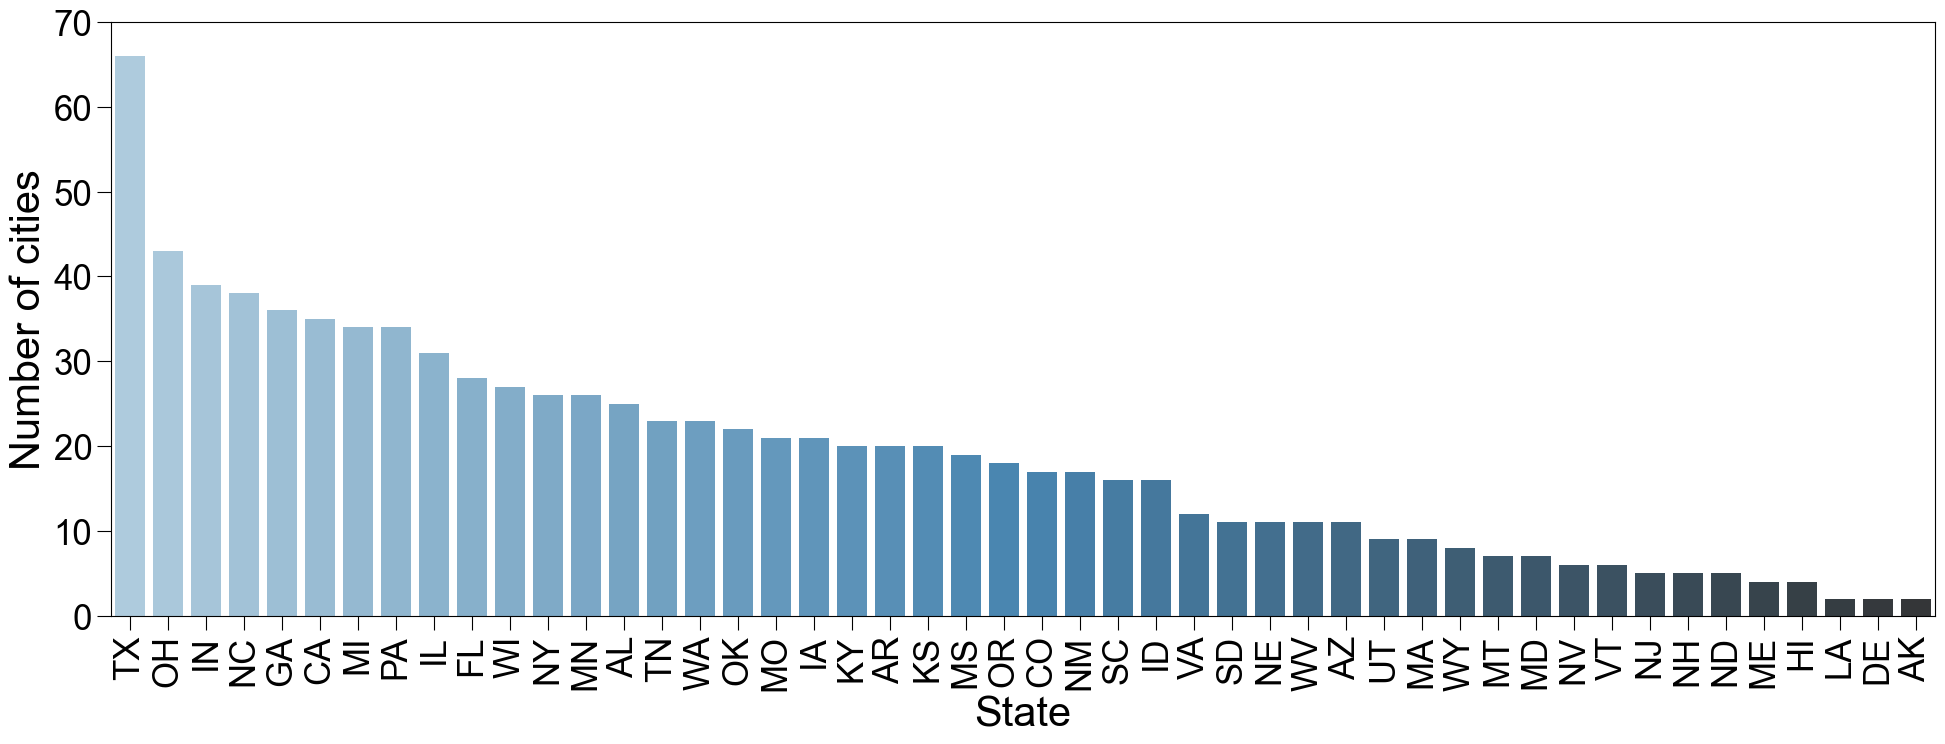

In [31]:
Specialty_Count_cbsa['State'] = [s[-2:] for s in Specialty_Count_cbsa['msa_name']]
df = Specialty_Count_cbsa.groupby('State')['cbsacode'].count().reset_index()
df.columns = ['State', 'CBSA_count']
df

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose you have a DataFrame with columns: ['State', 'CityCount']
# Replace this with your actual DataFrame
# Example mock data:
# data = pd.DataFrame({'State': [...], 'CityCount': [...]})
# Or if you already have a DataFrame:
# data = pd.read_csv("your_data.csv")

# Sort by city count
data_sorted = df.sort_values('CBSA_count', ascending=False)

# Set plot style
# sns.set(style="whitegrid")

# Create the bar plot
fig, ax = plt.subplots(figsize=(20, 8))

plt.rcParams.update({
    'font.size' : 25,
    "lines.linewidth": 2,
    'lines.markersize':10,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "it",    
    "mathtext.rm"  : "arial",
        })
barplot = sns.barplot(
    x='State',
    y='CBSA_count',
    data=data_sorted,
    palette='Blues_d'
)

# Label formatting
plt.yticks(size=20)
plt.ylim(0,70)
plt.tick_params(axis='x', labelsize=25, length=10,rotation=90)
plt.tick_params(axis='y', labelsize=25, length=10,)
plt.tight_layout()
plt.xlabel("State", )
plt.ylabel("Number of cities")
plt.tight_layout()
# plt.savefig('./count_state.pdf', dpi=300, bbox_inches = 'tight')

plt.show()


### Fit for Medical diversity

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_43859/817141622.py:4: RuntimeWarning:

divide by zero encountered in power



[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.11888044e-01  3.32985745e+01 -3.50000000e-01  1.00574835e-03]
[ 7.118880

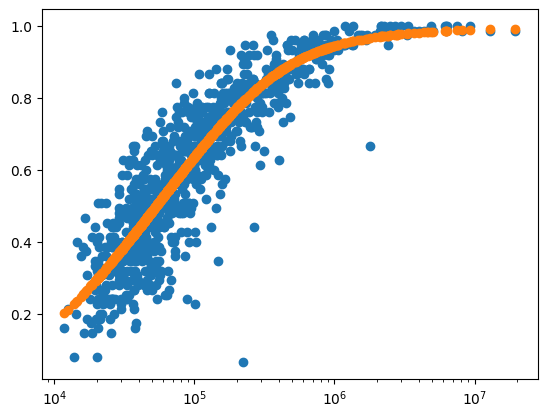

In [10]:
from scipy.optimize import curve_fit, differential_evolution, fsolve

def f(x, gamma, x0, zeta, A, Dmax=75):
    return A * x**(-gamma) * np.exp(-x/x0) * np.exp(1 - (1 - x/Dmax)**zeta)

# def objective(params):
#     gama, x0, zeta, A = params
#     preds = f(All_xs, gama, x0, zeta, A, Dmax=Dmax)
#     return np.sum((preds - All_fs)**2)

def inverse_f(y, params):
    gamma, x0, zeta, A = params
    print(params)
    return fsolve(lambda x: f(x, gamma, x0, zeta, A) - y, x0=1)[0] 

def objective(params):
    gamma, x0, zeta, A = params
    preds = f(x, gamma, x0, zeta, A, Dmax=75)
    return np.sum((preds - f_mean)**2)


bounds = [(0, 10), (0, 70), (-10, -0.35), (0, 10)]

result = differential_evolution(objective, bounds, popsize=100,
                                                        tol=1e-8,
                                                        maxiter=4000,
                                                        polish=True)
Dn_model = []
for n in df["Population"]:
    Dn_model.append(inverse_f(1/n, result.x))

plt.scatter(df["Population"],df["DN"]/Dmax)
plt.scatter(df["Population"],np.array(Dn_model)/Dmax)
plt.xscale("log")
plt.show()

1 0.0012921751615218953
1 0.0007116056410919912
1 0.0011068830503714391
1 0.0016407959162412751
1 0.0005742411812961444
1 0.0009435880400573885
1 0.001016924529672405
1 0.0010430153934685657
1 0.0010514885779476042
1 0.0004943116140414918
1 0.0007947543998885797
1 0.0014003257279410646
1 0.0024578076355890547
1 0.0009400452783054464
1 0.0008760293344679999
1 0.0009448472863107009
1 0.0010268386077579546
1 0.0008702378650164379
1 0.0009687240520343206
1 0.0010309878360064187
1 0.000851270825732701
1 0.0008296774904091485
1 0.0035611683026095286
1 0.0005273418773370834
1 0.0013969058842352709
1 0.0007697293793550478
1 0.00020682059434756823
1 0.0013979471242230588
1 0.0008674814693933642
1 0.000977953439677316
1 0.0009539743337759647
1 0.0010461778015668337
1 0.0011960577935125826
1 0.0009053134938136911
1 0.0010357561019544268
1 0.000595821228897932
1 0.0009166547240166241
1 0.000657850573941062
1 0.0006647319989086489
1 0.0005894231120587072
1 0.0016108880314948256
1 0.0011233711118877

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_43859/475920448.py:71: RuntimeWarning:

divide by zero encountered in scalar power

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_43859/475920448.py:71: RuntimeWarning:

invalid value encountered in scalar power



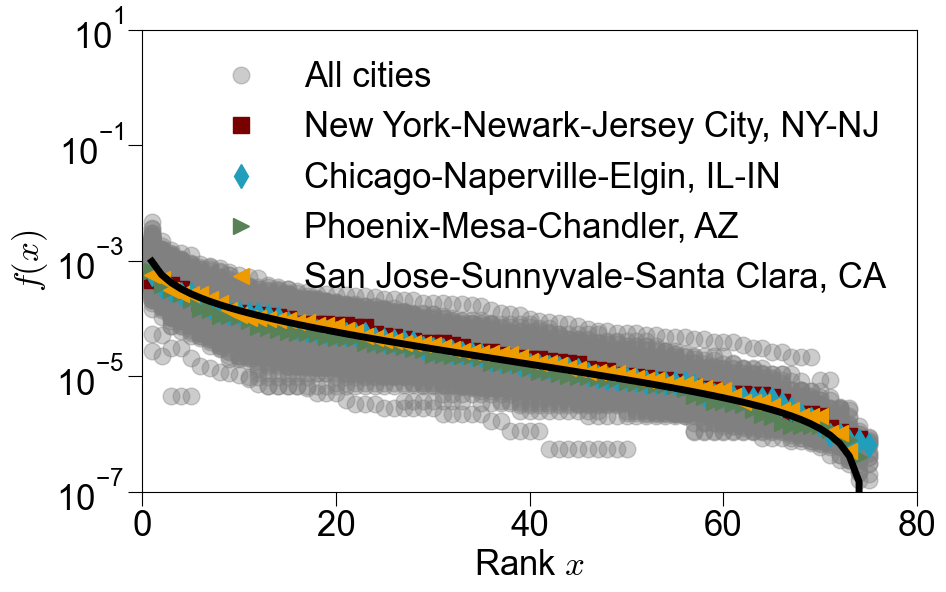

In [32]:
# fig, ax = plt.subplot(figsize=(10,8))
df_CountBySpecialty = CountBySpecialty.merge(df_analysis.Specialty, on='Specialty')
def plot_fig2(cbsa,mark,color):
    city_data = df_CountBySpecialty[df_CountBySpecialty['cbsa'] == cbsa].copy()
    city_data = city_data.sort_values(by='Count', ascending=False).reset_index(drop=True)
    city_data['Rank'] = city_data.index + 1
    total_practitioners = city_data['Count'].sum()
    total_specialties = len(city_data)
    city_data['Normalized_Abundance'] = city_data['Count'] / city_data['msa_pop']
    # print(city_data['Normalized_Abundance'].max())
    city_data['Normalized_Rank'] = city_data['Rank'] / total_specialties
    # Plot
    ax = plt.plot(city_data['Rank'], city_data['Normalized_Abundance'], marker='{}'.format(str(mark)),linewidth=0, markersize=12,
                  label=city_data.msa_name.iloc[0],color='{}'.format(str(color)), alpha=1)

custom_colors = ['#780000','#ae2012','#bb3e03','#ca6702','#ee9b00','#e9d8a6',
                 '#94d2bd','#2a9d8f','#0a9396',
                #  '#005f73','#001219',
                '#219ebc',
                 '#219ebc','#1d3557','#0d1b2a']
plt.figure(figsize=(10, 6))

plt.rcParams.update({
    'font.size' : 25,
    "lines.linewidth": 2,
    'lines.markersize':12,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "it",
    "mathtext.rm"  : "arial",
        })
for city in df_CountBySpecialty['cbsa'].unique():
    city_data = df_CountBySpecialty[df_CountBySpecialty['cbsa'] == city].copy()
    city_data = city_data.sort_values(by='Count', ascending=False).reset_index(drop=True)
    city_data['Rank'] = city_data.index + 1
    total_practitioners = city_data['Count'].sum()
    total_specialties = len(city_data)
    city_data['Normalized_Abundance'] = city_data['Count'] / city_data['msa_pop']
    city_data['Normalized_Rank'] = city_data['Rank'] / total_specialties

    print(city_data['Rank'][0], city_data['Normalized_Abundance'][0])

    # Plot
    ax = plt.plot(city_data['Rank'], city_data['Normalized_Abundance'], marker='o',linewidth=0,color='grey', alpha=0.4,)
ax = plt.plot(city_data['Rank'], city_data['Normalized_Abundance'], marker='o',linewidth=0,color='grey', alpha=0.4,label='All cities')
plot_fig2(35620,mark='s',color='#780000')
plot_fig2(16980,mark='d',color='#219ebc')
plot_fig2(38060,mark='>',color='#588157')
plot_fig2(41940,mark='<',color='#ee9b00')
# city_data = CountBySpecialty[CountBySpecialty['cbsa'] == ].copy()
# city_data = city_data.sort_values(by='Count', ascending=False).reset_index(drop=True)
# city_data['Rank'] = city_data.index + 1
# total_practitioners = city_data['Count'].sum()
# total_specialties = len(city_data)
# city_data['Normalized_Abundance'] = city_data['Count'] / total_practitioners
# city_data['Normalized_Rank'] = city_data['Rank'] / total_specialties
# # Plot
# ax = plt.plot(city_data['Rank'], city_data['Normalized_Abundance'], marker='d',linewidth=0, label=city,color='red', alpha=1)
plt.xlim(0,80)
plt.ylim(10**(-7),10**(1))
# plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False, loc='upper right')
plt.xlabel('Rank $x$')
plt.ylabel('$f(x)$')

gamma, x0, zeta, A = np.array([7.11887435e-01 , 3.32984422e+01 ,-3.50000000e-01 , 1.00575828e-03])

def f(x, gamma, x0, zeta, A, Dmax=75):
    return A * x**(-gamma) * np.exp(-x/x0) * np.exp(1 - (1 - x/Dmax)**zeta)

plt.plot(np.arange(1,100), [f(x,gamma, x0, zeta, A, Dmax=75) for x in np.arange(1,100)], color='black', linewidth=5)

plt.yticks(size=20)
plt.tick_params(axis='x', labelsize=25, length=10,)
plt.tick_params(axis='y', labelsize=25, length=10,)

# plt.savefig('Abundance_Rank.pdf', dpi=300, bbox_inches = 'tight')

In [11]:
cbsa_shape = gpd.read_file("./tl_2024_us_cbsa/tl_2024_us_cbsa.shp")
cbsa_shape['cbsacode'] = cbsa_shape['GEOID'].astype('int')
cbsa_shape

CSAFP CBSAFP  GEOID         GEOIDFQ                            NAME  \
0     490  11640  11640  310M700US11640                     Arecibo, PR   
1     NaN  11660  11660  310M700US11660                 Arkadelphia, AR   
2     556  11680  11680  310M700US11680      Arkansas City-Winfield, KS   
3     120  11700  11700  310M700US11700                   Asheville, NC   
4     360  11740  11740  310M700US11740                     Ashland, OH   
..    ...    ...    ...             ...                             ...   
930   218  37800  37800  310M700US37800                       Pella, IA   
931   NaN  37860  37860  310M700US37860  Pensacola-Ferry Pass-Brent, FL   
932   427  37900  37900  310M700US37900                      Peoria, IL   
933   294  37940  37940  310M700US37940                        Peru, IN   
934   NaN  37950  37950  310M700US37950                    Petoskey, MI   

                                      NAMELSAD LSAD MEMI  MTFCC       ALAND  \
0                       Arecibo, PR Metro Area   M1    1  G3110   613528952   
1                   Arkadelphia, AR Micro Area   M2    2  G3110  2242855174   
2        Arkansas City-Winfield, KS Micro Area   M2    2  G3110  2915648172   
3                     Asheville, NC Metro Area   M1    1  G3110  3830729933   
4                       Ashland, OH Micro Area   M2    2  G3110  1095528191   
..                                         ...  ...  ...    ...         ...   
930                       Pella, IA Micro Area   M2    2  G3110  1436123089   
931  Pensacola-Ferry Pass-Brent, FL Metro Area   M1    1  G3110  4323723291   
932                      Peoria, IL Metro Area   M1    1  G3110  6391181524   
933                        Peru, IN Micro Area   M2    2  G3110   968246955   
934                    Petoskey, MI Micro Area   M2    2  G3110  1210937829   

         AWATER     INTPTLAT      INTPTLON  \
0     231467259  +18.4392239  -066.7599813   
1      43965580  +34.0533162  -093.1762085   
2      17322934  +37.2345068  -096.8372468   
3      19336007  +35.6163405  -082.5706835   
4       9969109  +40.8432730  -082.2701271   
..          ...          ...           ...   
930    41484609  +41.3314327  -093.0938678   
931  1757254546  +30.6085566  -087.1585466   
932   130518754  +40.7880685  -089.5146389   
933     9184623  +40.7728833  -086.0442575   
934  1073422144  +45.5900944  -084.9868217   

                                              geometry  cbsacode  
0    POLYGON ((-66.96346 18.47302, -66.96337 18.473...     11640  
1    POLYGON ((-93.50221 34.21413, -93.50221 34.214...     11660  
2    POLYGON ((-96.82595 37.47613, -96.81015 37.476...     11680  
3    POLYGON ((-82.40860 35.81818, -82.40815 35.818...     11700  
4    POLYGON ((-82.22067 40.66736, -82.22112 40.667...     11740  
..                                                 ...       ...  
930  POLYGON ((-93.09922 41.16087, -93.10304 41.160...     37800  
931  POLYGON ((-86.91833 30.21764, -86.92528 30.216...     37860  
932  POLYGON ((-89.04724 41.01330, -89.04724 41.012...     37900  
933  POLYGON ((-86.01332 40.56413, -86.01355 40.564...     37940  
934  POLYGON ((-84.96479 45.29160, -84.96671 45.286...     37950  

[935 rows x 15 columns]

In [12]:
df_cbsa = CountBySpecialty[['cbsa','msa_name','msa_pop']].drop_duplicates()
df_cbsa.columns = ['cbsacode','msa_name','Population']
Specialty_Count_cbsa = df_cbsa.merge(new_df,on='cbsacode')
Specialty_Count_cbsa['log_Population'] = np.log(Specialty_Count_cbsa['Population'])
Specialty_Count_cbsa = Specialty_Count_cbsa.merge(cbsa_shape[['cbsacode','ALAND']], on='cbsacode')
Specialty_Count_cbsa['Population_density'] = Specialty_Count_cbsa['Population']/Specialty_Count_cbsa['ALAND'].astype('float')
Specialty_Count_cbsa

cbsacode           msa_name  Population  PATHOLOGY  \
0     10100.0       Aberdeen, SD       41790        2.0   
1     10140.0       Aberdeen, WA       77290        2.0   
2     10180.0        Abilene, TX      181591        4.0   
3     10220.0            Ada, OK       38396        2.0   
4     10300.0         Adrian, MI       97520       11.0   
..        ...                ...         ...        ...   
893   33740.0         Monroe, LA      221885        0.0   
894   34300.0  Mountain Home, ID       29724        0.0   
895   39700.0   Raymondville, TX       20037        0.0   
896   42900.0   Seneca Falls, NY       32349        0.0   
897   49820.0         Zapata, TX       13736        0.0   

     CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)  GYNECOLOGICAL ONCOLOGY  \
0                                             27.0                     0.0   
1                                              1.0                     0.0   
2                                             77.0                     0.0   
3                                             11.0                     0.0   
4                                             31.0                     0.0   
..                                             ...                     ...   
893                                            0.0                     0.0   
894                                            0.0                     0.0   
895                                            0.0                     0.0   
896                                            0.0                     0.0   
897                                            0.0                     0.0   

     EMERGENCY MEDICINE  HOSPITALIST  FAMILY PRACTICE  OBSTETRICS/GYNECOLOGY  \
0                   4.0          3.0             11.0                    7.0   
1                  18.0          2.0             19.0                    3.0   
2                  24.0          3.0             87.0                   15.0   
3                  34.0          2.0             40.0                    9.0   
4                   3.0          1.0             20.0                    4.0   
..                  ...          ...              ...                    ...   
893                 0.0          0.0              1.0                    0.0   
894                 0.0          0.0              9.0                    0.0   
895                 0.0          0.0              5.0                    0.0   
896                 0.0          0.0              6.0                    0.0   
897                 0.0          0.0              1.0                    0.0   

     ...  PERIPHERAL VASCULAR DISEASE  ORAL AND MAXILLOFACIAL RADIOLOGY  \
0    ...                          0.0                               0.0   
1    ...                          0.0                               0.0   
2    ...                          0.0                               0.0   
3    ...                          0.0                               0.0   
4    ...                          0.0                               0.0   
..   ...                          ...                               ...   
893  ...                          0.0                               0.0   
894  ...                          0.0                               0.0   
895  ...                          0.0                               0.0   
896  ...                          0.0                               0.0   
897  ...                          0.0                               0.0   

     DENTAL ANESTHESIOLOGY  PROSTHODONTICS  ORAL MEDICINE  \
0                      0.0             0.0            0.0   
1                      0.0             0.0            0.0   
2                      0.0             0.0            0.0   
3                      0.0             0.0            0.0   
4                      0.0             0.0            0.0   
..                     ...             ...            ...   
893                    0.0             0.0            0.0   
894      

### Logistic regression + OLS for urban scaling

In [13]:
CI_lower = []
CI_upper = []
CIs = []
scaling_exponent = []

scaling_density = []
CI_lower_density = []
CI_upper_density = []
CIs_density = []


R2 = []
# Specialty = []

logit_population = []
CI_lower_N = []
CI_upper_N = []
CIs_N = []

Gini = []
Gini_SAMI = []


for s in df_analysis.Specialty:
    # print()

    Specialty_Count_cbsa[s+'_HAS'] = (Specialty_Count_cbsa[s]>0).astype(int)

    # logistic model 
    X = sm.add_constant(Specialty_Count_cbsa[['log_Population']])
    logit_model = sm.Logit(Specialty_Count_cbsa[[s+'_HAS']],X).fit()
    CI_lower_N.append(logit_model.conf_int().iloc[1,:][0])
    CI_upper_N.append(logit_model.conf_int().iloc[1,:][1])
    CIs_N.append(tuple((logit_model.conf_int().iloc[1,:][0],logit_model.conf_int().iloc[1,:][1])))
    logit_population.append(logit_model.params[1])
    # print(s, logit_model.params[1], CIs, tuple((logit_model.conf_int().iloc[1,:][0],logit_model.conf_int().iloc[1,:][1])))
    df_pos = Specialty_Count_cbsa[Specialty_Count_cbsa[s]>0].copy()

    CI,SAMIs,beta,r2 = scaling_iloc(df_pos["Population"],df_pos[s], s)
    # Specialty_Count_cbsa['SAMI_'+s] = SAMIs

    CI_density,SAMIs_density,beta_density,r2_density = scaling_iloc(df_pos["Population_density"],df_pos[s], s)

    CI_lower.append(CI[0])
    CI_upper.append(CI[1])
    CIs.append(tuple((CI[0],CI[1])))
    scaling_exponent.append(beta)
    R2.append(r2)
    # G = getGini(np.array(Specialty_Count_cbsa[s]/Specialty_Count_cbsa['Population']))
    G = getGini(np.exp(np.array(SAMIs)))
    Gini.append(G)
    Gini_SAMI.append(getGini(np.exp(np.array(SAMIs_density))))


    scaling_density.append(beta_density)
    CI_lower_density.append(CI_density[0])
    CI_upper_density.append(CI_density[1])
    CIs_density.append(tuple((CI_density[0],CI_density[1])))





Optimization terminated successfully.
         Current function value: 0.397880
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172716
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.507119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.074884
         Iterations 10
         Current function value: 0.000000
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.483175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368246
         Iterations 7
Optimization te

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/

Optimization terminated successfully.
         Current function value: 0.418428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.170288
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.318018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.303400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407572
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.284503
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046486
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.183545
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.405814
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.191968
 

In [14]:


# Specialty_Count_cbsa

new_scaling = pd.DataFrame({
    'Specialty': df_analysis.Specialty,

    'Population_effect': logit_population,
    'CIs_betaN': CIs_N,


    'Scaling_exponent': scaling_exponent,
    
    'CI': CIs,
    'R^2':R2,

    'Scaling_density': scaling_density,
    'CI_density': CIs_density,

    'Gini_SAMI':Gini,
    'Gini_SAMI_density':Gini_SAMI,
    # 'Scaling_test': scaling_percent,
})

new_scaling

Specialty  Population_effect  \
0                               DERMATOLOGY           1.780619   
1   MICROGRAPHIC DERMATOLOGIC SURGERY (MDS)           1.399535   
2                        EMERGENCY MEDICINE           1.611305   
3                           SPORTS MEDICINE           1.263869   
4                   HOSPICE/PALLIATIVE CARE           1.630814   
..                                      ...                ...   
70        OSTEOPATHIC MANIPULATIVE MEDICINE           1.088476   
71            MARRIAGE AND FAMILY THERAPIST           1.008917   
72                  MENTAL HEALTH COUNSELOR           0.974589   
73                   CLINICAL SOCIAL WORKER           1.807548   
74                                  UROLOGY           1.894447   

                                   CIs_betaN  Scaling_exponent  \
0   (1.4664132220134878, 2.0948239412895058)             0.974   
1    (1.1935943760588676, 1.605475220862509)             0.379   
2   (1.0749851065218237, 2.1476247118247636)             0.918   
3    (1.0818065328591684, 1.445931699062961)             0.606   
4   (1.4095577798997383, 1.8520700084800261)             0.682   
..                                       ...               ...   
70  (0.9232226097877962, 1.2537285375108649)             0.351   
71   (0.8530794024519592, 1.164753901461659)             0.400   
72  (0.7751791026767054, 1.1739982653764458)             0.641   
73  (1.2855343877598557, 2.3295622086124297)             0.960   
74   (1.5198579034570063, 2.269037096431852)             0.906   

                                            CI   R^2  Scaling_density  \
0       (0.940868894425284, 1.007614637095216)  0.78            0.784   
1   (0.31875874769630974, 0.43936469202118766)  0.49            0.361   
2     (0.8836825439717008, 0.9527866427299526)  0.68            0.734   
3     (0.5562191642342201, 0.6563458230191744)  0.62            0.604   
4     (0.6225797458724724, 0.7422228973702338)  0.64            0.639   
..                                         ...   ...              ...   
70    (0.2828191182293869, 0.4196125968679856)  0.37            0.334   
71  (0.32605414396365845, 0.47409197565138245)  0.35            0.303   
72    (0.5782962978515773, 0.7039195748420832)  0.46            0.542   
73     (0.9183501049633707, 1.001715045541522)  0.66            0.788   
74    (0.8778130084670497, 0.9345082308317931)  0.79            0.805   

                                    CI_density  Gini_SAMI  Gini_SAMI_density  
0     (0.6922762741846676, 0.8749973516828414)   0.344481           0.578997  
1   (0.24636475225802082, 0.47647187515050504)   0.311459           0.393864  
2      (0.647809332021176, 0.8208950327217206)   0.375464           0.551819  
3     (0.5075958806478857, 0.7007772244021728)   0.338805           0.476286  
4     (0.5200049717522874, 0.7584246444379918)   0.361732           0.492542  
..                                         ...        ...                ...  
70  (0.24408660757739434, 0.42310861306901526)   0.416298           0.449265  
71    (0.2068379442584082, 0.3986811970594857)   0.489811           0.587641  
72    (0.4557213494282473, 0.6282369279209812)   0.455492           0.556807  
73    (0.7054766366549141, 0.8697815964257318)   0.425388           0.585960  
74    (0.7302367268290129, 0.8793806611709296)   0.311945           0.505653  

[75 rows x 10 columns]

In [20]:
new_scaling = new_scaling.sort_values(by='Scaling_exponent',)
df_NEW = new_scaling.merge(df_analysis, on='Specialty')
# df_NEW = new_scaling.sort_values(by='Scaling_exponent').copy()
df_NEW

Specialty  Population_effect  \
0                        ADDICTION MEDICINE           1.047778   
1                       PREVENTIVE MEDICINE           1.132855   
2         OSTEOPATHIC MANIPULATIVE MEDICINE           1.088476   
3   MICROGRAPHIC DERMATOLOGIC SURGERY (MDS)           1.399535   
4                     MAXILLOFACIAL SURGERY           1.249382   
..                                      ...                ...   
70                      PHYSICIAN ASSISTANT           1.953378   
71                    CLINICAL PSYCHOLOGIST           1.790953   
72                         PHYSICAL THERAPY           1.788588   
73                        INTERNAL MEDICINE           2.922746   
74                           ANESTHESIOLOGY           2.216978   

                                   CIs_betaN  Scaling_exponent  \
0    (0.8835897624391873, 1.211966504643965)             0.305   
1    (0.953882584283166, 1.3118273391582513)             0.331   
2   (0.9232226097877962, 1.2537285375108649)             0.351   
3    (1.1935943760588676, 1.605475220862509)             0.379   
4   (1.0623312210368974, 1.4364332380555245)             0.398   
..                                       ...               ...   
70  (0.9807421645385669, 2.9260131874875555)             1.057   
71  (1.4877074907730898, 2.0941983304593004)             1.069   
72   (1.2033510559594927, 2.373823997160013)             1.089   
73     (1.556677931143937, 4.28881313094189)             1.100   
74  (1.8148434193089733, 2.6191132666927124)             1.154   

                                            CI   R^2  Scaling_density  \
0     (0.2448968761941547, 0.3644647069176129)  0.38            0.372   
1    (0.26493758011173496, 0.3965108309634293)  0.46            0.358   
2     (0.2828191182293869, 0.4196125968679856)  0.37            0.334   
3   (0.31875874769630974, 0.43936469202118766)  0.49            0.361   
4     (0.3193439389529985, 0.4772718260029427)  0.39            0.475   
..                                         ...   ...              ...   
70        (1.017405777924903, 1.0956631504036)  0.72            0.888   
71     (1.0258633829697972, 1.111415988465945)  0.73            0.916   
72     (1.052749186479573, 1.1262500604735801)  0.77            0.844   
73    (1.0715569486810836, 1.1283916880331968)  0.83            0.962   
74     (1.1177475685671237, 1.190820220938182)  0.77            0.977   

                                    CI_density  Gini_SAMI  Gini_SAMI_density  \
0    (0.2741901619067174, 0.47035984514373574)   0.334321           0.372746   
1   (0.25751609002972686, 0.45796526054200704)   0.334491           0.409295   
2   (0.24408660757739434, 0.42310861306901526)   0.416298           0.449265   
3   (0.24636475225802082, 0.47647187515050504)   0.311459           0.393864   
4      (0.3363737124020987, 0.612633474962165)   0.398151           0.450513   
..                                         ...        ...                ...   
70    (0.8055572016419091, 0.9698560390429111)   0.386433           0.581382   
71    (0.8175749370447629, 1.0143065943341585)   0.428459           0.611911   
72    (0.7546934175019208, 0.9341394131805846)   0.378567           0.612866   
73    (0.8846774098455025, 1.0387433755892368)   0.310511           0.547496   
74     (0.8786827055848444, 1.075130769793107)   0.406196           0.614884   

    PageRank  katz_centrality  in_degree_centrality  out_degree_centrality  \
0   0.017033         0.109982              0.013514               0.000000   
1   0.009207         0.099984              0.000000               0.013514   
2   0.014511         0.111092              0.013514               0.000000   
3   0.017033         0.109982              0.013514               0.000000   
4   0.010772         0.109982              0.013514               0.000000   
..       ...              ...                   ...                    ...   
70  0.012468         0.119980              0.027027             

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_43859/1727840434.py:114: UserWarning:

The figure layout has changed to tight



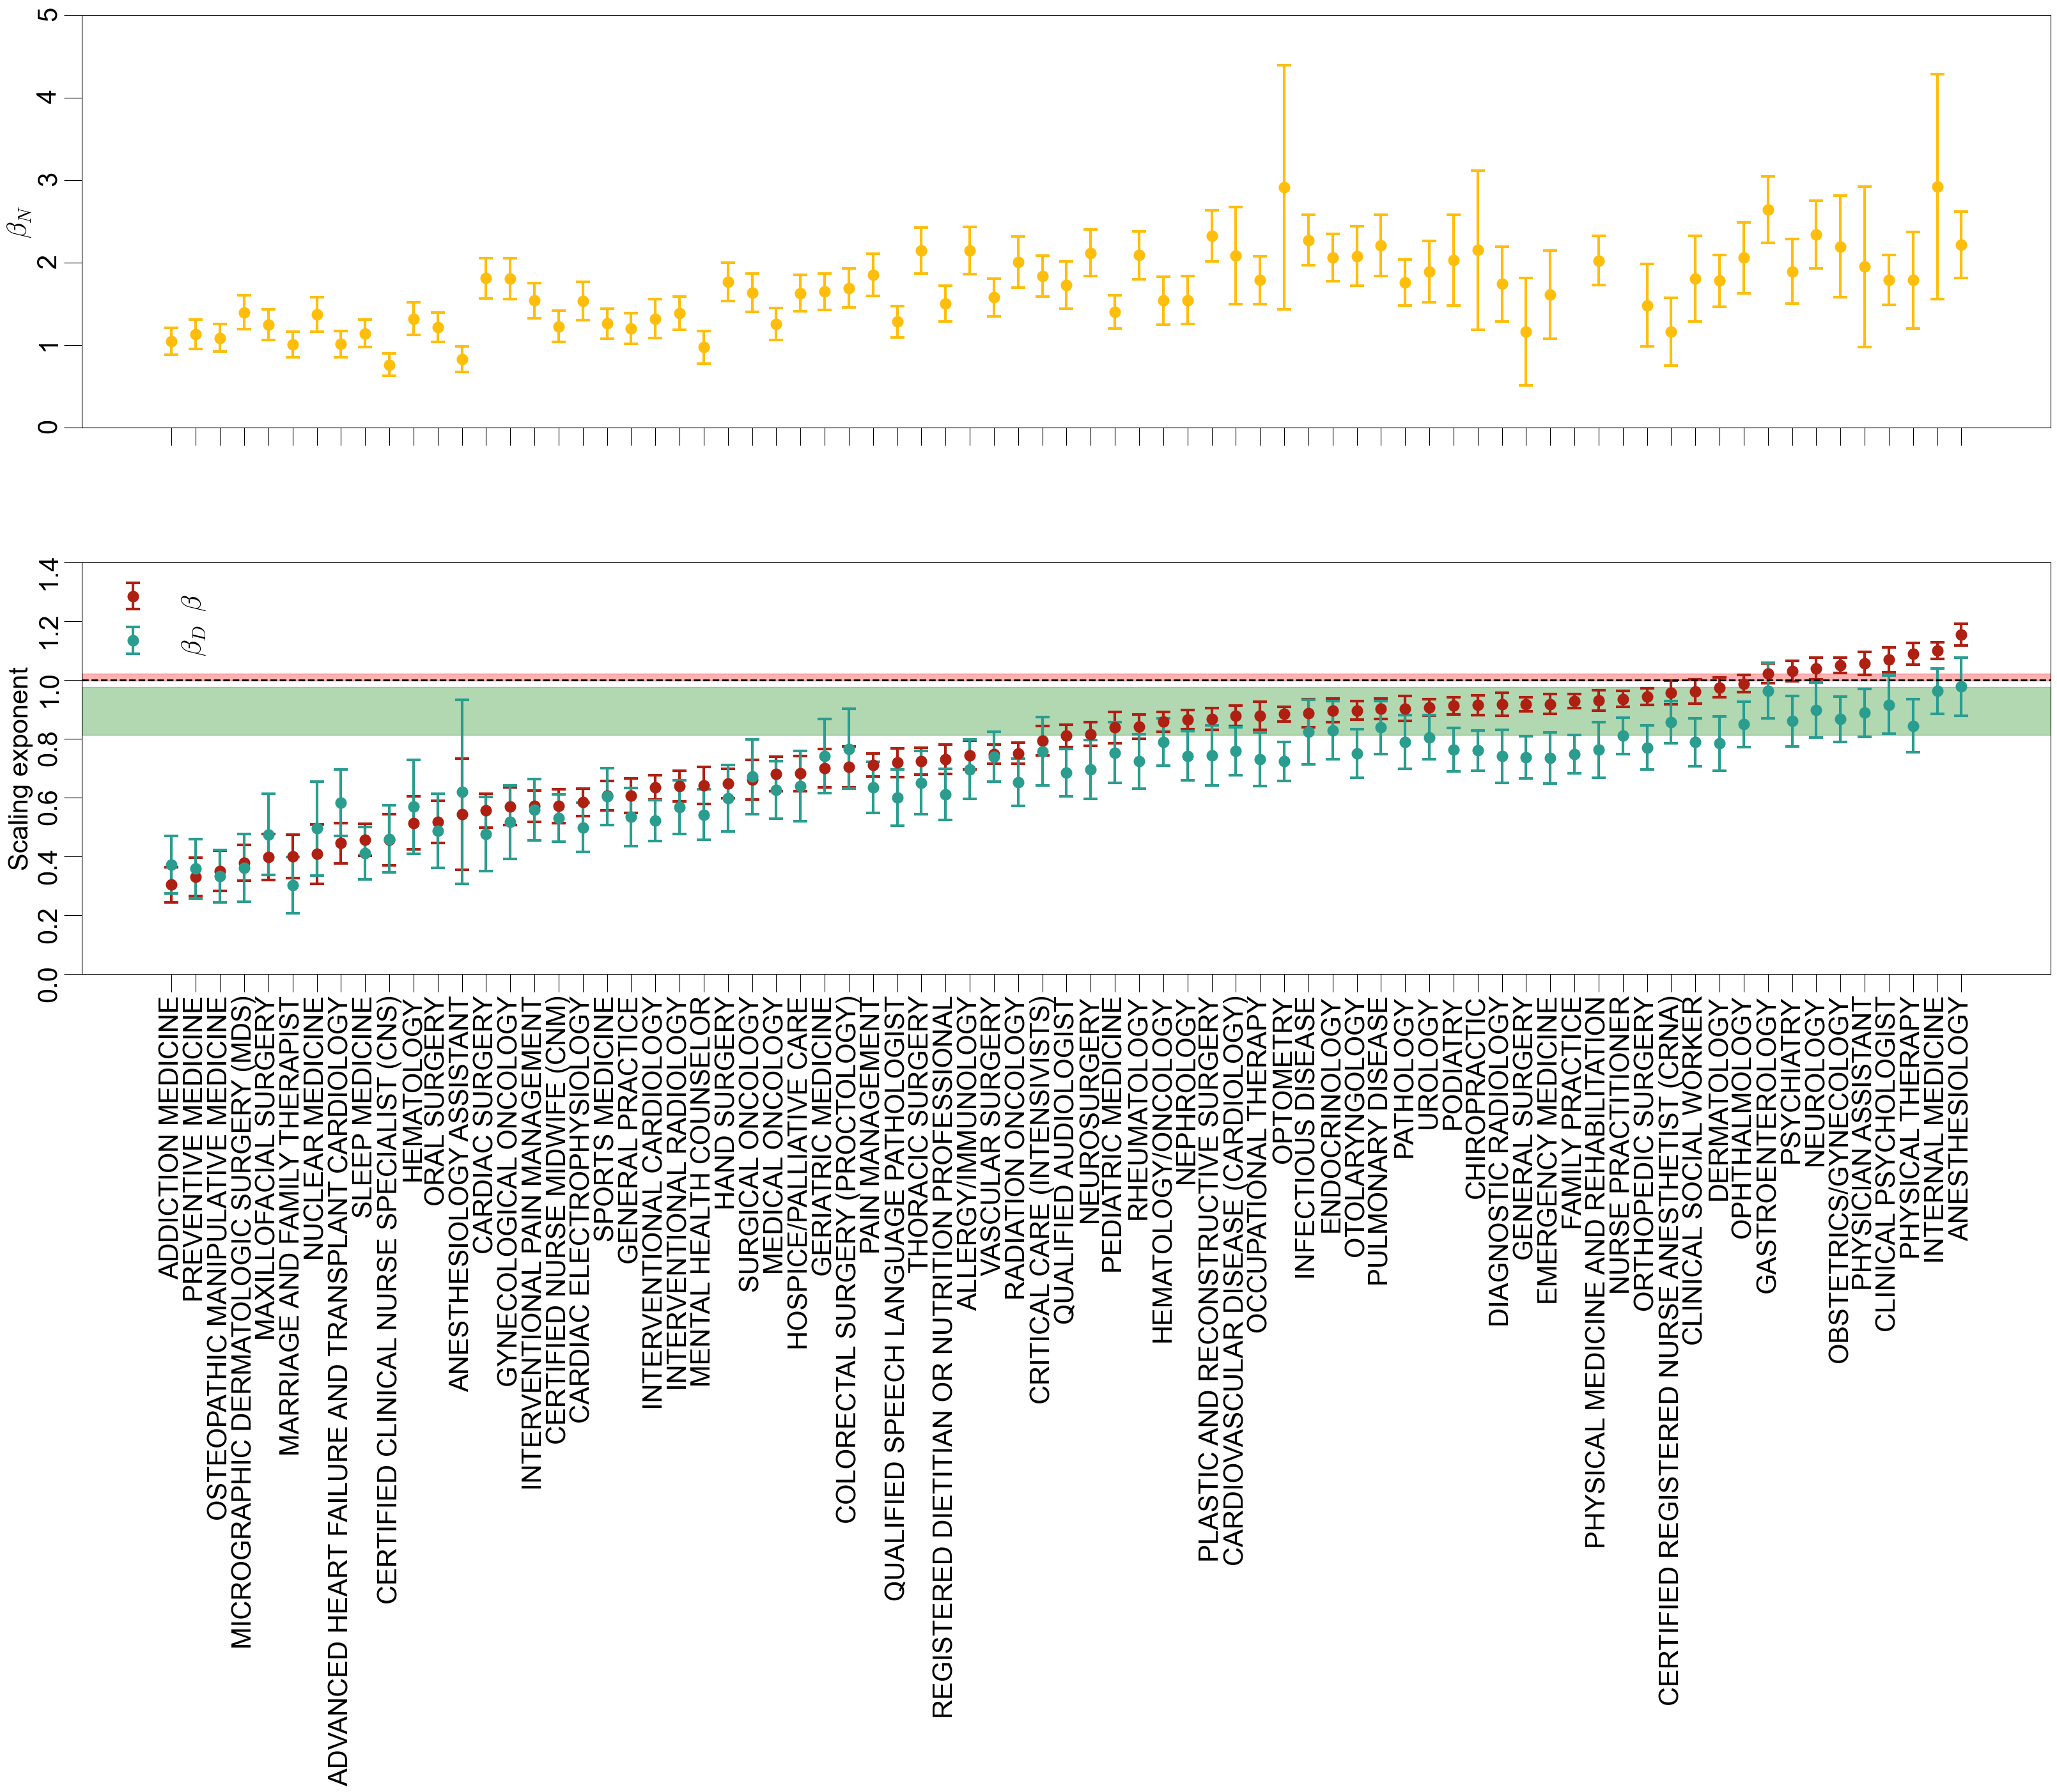

In [ ]:
hfont = {'fontname':'Arial'}

font_color = 'black'
color_red = '#ae2012'
color_blue = '#669bbc'
color_green = '#2a9d8f'
color_yellow = '#ffbe0b'

fig, axes = plt.subplots(2,1, figsize=(40,20),sharex=True)
fig.tight_layout()


plt.rcParams.update({
    'font.size' : 30,
    "lines.linewidth": 2,
    'lines.markersize':10,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "it",
    "mathtext.rm"  : "arial",
        })

red_upper = 1.021
red_lower = 0.998

green_upper = 0.976
green_lower = 0.812

# Unpack tuple values into two separate lists
lower_error = np.array([df_NEW['Scaling_exponent'].iloc[i]-df_NEW['CI'].iloc[i][0] for i in range(len(df_NEW['CI']))])
upper_error = np.array([df_NEW['CI'].iloc[i][1] - df_NEW['Scaling_exponent'].iloc[i] for i in range(len(df_NEW['CI']))])

# Combine for asymmetric error bars
asymmetric_error = [lower_error, upper_error]

# axes[0].barh(df_NEW['Specialty'], df_NEW['Scaling_exponent'], xerr=asymmetric_error, align='center', color=color_red,zorder=10,capsize=3, height=0.8)
# axes[0].plot(df_NEW['Scaling_exponent'], df_NEW['Specialty'])
axes[1].errorbar(df_NEW['Specialty'],df_NEW['Scaling_exponent'],  yerr=asymmetric_error, fmt='o',capsize=8, elinewidth=3, markeredgewidth=3, color=color_red, label=r'$\beta$')


lower_error = np.array([df_NEW['Scaling_density'].iloc[i]-df_NEW['CI_density'].iloc[i][0] for i in range(len(df_NEW['CI']))])
upper_error = np.array([df_NEW['CI_density'].iloc[i][1] - df_NEW['Scaling_density'].iloc[i] for i in range(len(df_NEW['CI']))])

# Combine for asymmetric error bars
asymmetric_error = [lower_error, upper_error]
axes[1].errorbar(df_NEW['Specialty'], df_NEW['Scaling_density'], yerr=asymmetric_error, fmt='o',capsize=8, elinewidth=3, markeredgewidth=3, color=color_green, label=r'$\beta_D$')
# axes.set_title(r'$\beta$', fontsize=20, pad=15, color='black', **hfont, rotation=-90)

# axes[0].set_title(r'$\beta$', fontsize=20, pad=15, color='black', **hfont)
# axes[1].barh(df_NEW['Specialty'], df_NEW['Population_effect'], align='center', color=color_blue, zorder=10, height=0.8)


df_NEW_ = df_NEW[~df_NEW['Specialty'].isin(['FAMILY PRACTICE','NURSE PRACTITIONER'])]

lower_error = np.array([df_NEW_['Population_effect'].iloc[i]-df_NEW_['CIs_betaN'].iloc[i][0] for i in range(len(df_NEW_['CI']))])
upper_error = np.array([df_NEW_['CIs_betaN'].iloc[i][1] - df_NEW_['Population_effect'].iloc[i] for i in range(len(df_NEW_['CI']))])

# Combine for asymmetric error bars
asymmetric_error = [lower_error, upper_error]
axes[0].errorbar(df_NEW_['Specialty'], df_NEW_['Population_effect'], yerr=asymmetric_error, fmt='o',capsize=8, elinewidth=3, markeredgewidth=3, color=color_yellow, )
# axes[1].set_title(r'$\beta_N$', fontsize=20, pad=15, color='black', **hfont)


axes[1].set_ylabel('Scaling exponent', rotation=90)
legend = axes[1].legend(frameon=False,loc='upper left',)

for text in legend.get_texts():
    text.set_rotation(90)

axes[0].set_ylabel(r'$\beta_N$', rotation=90)
# axes[0].legend(frameon=False,loc='upper left')

axes[1].axhspan(red_lower, red_upper, color='red', alpha=0.3)
axes[1].axhspan(green_lower, green_upper, color='green', alpha=0.3)

axes[1].axhline(y=1,color='black',linestyle='--', linewidth=2, )

axes[1].set_ylim(0, 1.4)
axes[0].set_ylim(0, 5)

# Invert x-axis if necessary
# axes[0].invert_xaxis()
# plt.gca().invert_yaxis()
    
        
# axes[0].set(yticks=MSAdist_new.index, yticklabels=MSAdist_new.Scaling_exponent)
axes[0].xaxis.tick_bottom()
# axes[0].tick_params(axis='y', colors='black',size=10) # tick color


# # axes[0].set(yticks=MSAdist_new.index, yticklabels=MSAdist_new.Scaling_exponent)
# axes.yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black',size=20) # tick color
axes[0].tick_params(axis='x', colors='black',size=20,labelbottom=False) 
axes[1].tick_params(axis='x', colors='black',size=20) # tick color
axes[1].tick_params(axis='y', colors='black',size=20) 
# axes.yaxis.set_ticks_position('none')
# # axes[1].set_xticklabels([1000, 2000, 3000, 4000, 5000, 6000, 7000])

# axes[1].xaxis.set_ticks_position('none')
# axes.set_ylim(0,1.4)
# # axes[1].set_xlim(0,1)
for label in (axes[0].get_xticklabels()):
    label.set( rotation=90,color=font_color, **hfont)
for label in (axes[1].get_xticklabels()):
    label.set( rotation=90,color=font_color, **hfont)
for label in (axes[0].get_yticklabels()):
    label.set( color=font_color, **hfont,rotation=90)
for label in (axes[1].get_yticklabels()):
    label.set( color=font_color, **hfont,rotation=90)

# plt.legend()
plt.tight_layout()

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)


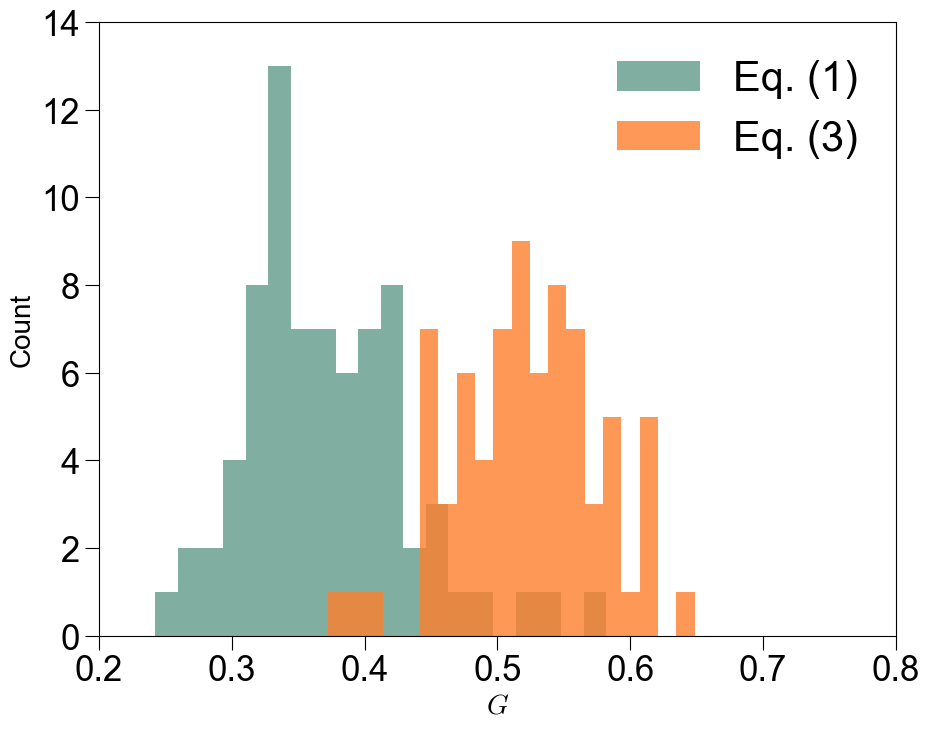

In [23]:
plt.figure(figsize=(10, 8))
df_NEW['Gini_SAMI'].hist(bins=20,label=r'Eq. (1)', alpha=.8, color='#619b8a')
df_NEW['Gini_SAMI_density'].hist(bins=20,label=r'Eq. (3)', alpha=.8, color='#fe7f2d')
# plt.scatter(df_NEW['Scaling_density'],df_NEW['Gini_SAMI'], color='lightblue', s=100, edgecolor='black')
# sns.regplot(x='Scaling_density', y='Gini_SAMI', data=df_NEW, scatter=False, color='black', line_kws={'linewidth': 2})
# plt.text(0.25, 1.1, r'$\rho={},\ p<0.001$'.format(str(np.round(corr,2))), 
#          fontsize=25, color='black')#, bbox=dict(facecolor='white', alpha=0.7))
# plt.text(0.25, 1, r'$\delta = {}, \gamma = {}$'.format(str(np.round(slope,2)), str(np.round(intercept,2))), 
#          fontsize=25, color='black')#, bbox=dict(facecolor='white', alpha=0.7))

plt.ylabel(r'Count', fontsize=20)
plt.xlabel(r'$G$', fontsize=20)

plt.xlim(0.2, .8)
plt.ylim(0,14)

plt.xticks(np.arange(0.2, .9, 0.1), fontsize=20)
plt.yticks(np.arange(0, 15, 2), fontsize=20)

plt.tick_params(axis='x', labelsize=25, length=10,)
plt.tick_params(axis='y', labelsize=25, length=10,)
plt.legend(frameon=False)
plt.tight_layout()
plt.grid(False)
plt.show()

# Normalized entropy

In [37]:
def normalized_entropy(row):
    values = row.values.astype(float)
    total = values.sum()
    
    if total == 0:
        return 0.0  # If no providers in city, entropy is 0
    
    p = values / total
    p_nonzero = p[p > 0]  # exclude zero entries
    k = len(p_nonzero)
    # return -np.sum(p_nonzero * np.log(p_nonzero))
    return -np.sum(p_nonzero * np.log(p_nonzero)) / np.log(k)

In [33]:
GDP_cbsa = pd.read_csv('./GDP_cbsa.csv')
GDP_cbsa

Unnamed: 0  cbsacode              cbsatitle    GDP_2019
0             0     10100           Aberdeen, SD   2423280.0
1             1     10140           Aberdeen, WA   2697837.0
2             2     10180            Abilene, TX   7792209.0
3             3     10220                Ada, OK   2100430.0
4             4     10300             Adrian, MI   3051416.0
..          ...       ...                    ...         ...
908         908     49660  Youngstown-Warren, OH  17218410.0
909         909     49700          Yuba City, CA   7100072.0
910         910     49740               Yuma, AZ   7968248.0
911         911     49780         Zanesville, OH   3846949.0
912         912     49820             Zapata, TX    630246.0

[913 rows x 4 columns]

In [35]:
df = GDP_cbsa.merge(Specialty_Count_cbsa, on='cbsacode',)
df_cbsa_spatial = cbsa_shape[['cbsacode','geometry']].merge(df, on=['cbsacode'])
# df_cbsa_spatial = df_cbsa_spatial.merge(, on=['cbsacode'], how='left')
df_cbsa_spatial['log_GDP'] = np.log(df_cbsa_spatial['GDP_2019'])
df_cbsa_spatial['State'] = [m[-2:] for m in df_cbsa_spatial.msa_name]
df_cbsa_spatial

cbsacode                                           geometry  \
0       11660  POLYGON ((-93.50221 34.21413, -93.50221 34.214...   
1       11680  POLYGON ((-96.82595 37.47613, -96.81015 37.476...   
2       11700  POLYGON ((-82.40860 35.81818, -82.40815 35.818...   
3       11740  POLYGON ((-82.22067 40.66736, -82.22112 40.667...   
4       11820  POLYGON ((-123.66230 45.77466, -123.67371 45.7...   
..        ...                                                ...   
888     37800  POLYGON ((-93.09922 41.16087, -93.10304 41.160...   
889     37860  POLYGON ((-86.91833 30.21764, -86.92528 30.216...   
890     37900  POLYGON ((-89.04724 41.01330, -89.04724 41.012...   
891     37940  POLYGON ((-86.01332 40.56413, -86.01355 40.564...   
892     37950  POLYGON ((-84.96479 45.29160, -84.96671 45.286...   

     Unnamed: 0_x                       cbsatitle    GDP_2019  Unnamed: 0_y  \
0              38                 Arkadelphia, AR    828301.0           639   
1              39      Arkansas City-Winfield, KS   1332368.0           640   
2              40                   Asheville, NC  20317731.0            30   
3              41                     Ashland, OH   1844299.0           858   
4              42                     Astoria, OR   1982996.0            31   
..            ...                             ...         ...           ...   
888           641                       Pella, IA   2281932.0           779   
889           642  Pensacola-Ferry Pass-Brent, FL  21931373.0           452   
890           643                      Peoria, IL  21416008.0           453   
891           644                        Peru, IN    999061.0           878   
892           645                    Petoskey, MI   1850423.0           454   

                           msa_name  Population  PATHOLOGY  \
0                   Arkadelphia, AR       21274        0.0   
1        Arkansas City-Winfield, KS       34157        0.0   
2                     Asheville, NC      417202       16.0   
3                       Ashland, OH       52190        0.0   
4                       Astoria, OR       41102        7.0   
..                              ...         ...        ...   
888                       Pella, IA       33770        0.0   
889  Pensacola-Ferry Pass-Brent, FL      530090       19.0   
890                      Peoria, IL      362240       35.0   
891                        Peru, IN       35402        0.0   
892                    Petoskey, MI       34123        3.0   

     CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)  ...  RHEUMATOLOGY_HAS  \
0                                              1.0  ...                 0   
1                                              3.0  ...                 0   
2                                            189.0  ...                 1   
3                                              0.0  ...                 0   
4                                             15.0  ...                 0   
..                                             ...  ...               ...   
888                                           10.0  ...                 1   
889                                          213.0  ...                 1   
890                                          147.0  ...                 1   
891                                            0.0  ...                 0   
892                                           13.0  ...                 0   

     SLEEP MEDICINE_HAS  SPORTS MEDICINE_HAS  SURGICAL ONCOLOGY_HAS  \
0                     0                    0                      0   
1                     0                    0                      0   
2                     0                    1                      0   
3                     0                    0                      0   
4                     0                    0                      0   
..                  ...                  ...                    ...   
888                   0                    0                      0   
8

In [38]:

# Exclude non-specialty columns
non_specialty_cols = ['cbsacode',
 'geometry',
 'Unnamed: 0',
 'cbsatitle',
 'GDP_2019',
 'Population',
 'log_Population',
 'Population_density',
 'msa_name',
 'Population',
 'log_Population',
 'Population_density',
 'state',
 'State',
 'log_GDP',
 'entropy_diversity']
# non_specialty_cols = df_cbsa_spatial.columns[:5].append(df_cbsa_spatial.columns[-7:])
df_entropy = df_cbsa_spatial
specialty_cols = [col for col in df_entropy.columns if col not in non_specialty_cols]

df_entropy['entropy_diversity_normalized'] = df_entropy[specialty_cols].apply(normalized_entropy, axis=1)
df_entropy

cbsacode                                           geometry  \
0       11660  POLYGON ((-93.50221 34.21413, -93.50221 34.214...   
1       11680  POLYGON ((-96.82595 37.47613, -96.81015 37.476...   
2       11700  POLYGON ((-82.40860 35.81818, -82.40815 35.818...   
3       11740  POLYGON ((-82.22067 40.66736, -82.22112 40.667...   
4       11820  POLYGON ((-123.66230 45.77466, -123.67371 45.7...   
..        ...                                                ...   
888     37800  POLYGON ((-93.09922 41.16087, -93.10304 41.160...   
889     37860  POLYGON ((-86.91833 30.21764, -86.92528 30.216...   
890     37900  POLYGON ((-89.04724 41.01330, -89.04724 41.012...   
891     37940  POLYGON ((-86.01332 40.56413, -86.01355 40.564...   
892     37950  POLYGON ((-84.96479 45.29160, -84.96671 45.286...   

     Unnamed: 0_x                       cbsatitle    GDP_2019  Unnamed: 0_y  \
0              38                 Arkadelphia, AR    828301.0           639   
1              39      Arkansas City-Winfield, KS   1332368.0           640   
2              40                   Asheville, NC  20317731.0            30   
3              41                     Ashland, OH   1844299.0           858   
4              42                     Astoria, OR   1982996.0            31   
..            ...                             ...         ...           ...   
888           641                       Pella, IA   2281932.0           779   
889           642  Pensacola-Ferry Pass-Brent, FL  21931373.0           452   
890           643                      Peoria, IL  21416008.0           453   
891           644                        Peru, IN    999061.0           878   
892           645                    Petoskey, MI   1850423.0           454   

                           msa_name  Population  PATHOLOGY  \
0                   Arkadelphia, AR       21274        0.0   
1        Arkansas City-Winfield, KS       34157        0.0   
2                     Asheville, NC      417202       16.0   
3                       Ashland, OH       52190        0.0   
4                       Astoria, OR       41102        7.0   
..                              ...         ...        ...   
888                       Pella, IA       33770        0.0   
889  Pensacola-Ferry Pass-Brent, FL      530090       19.0   
890                      Peoria, IL      362240       35.0   
891                        Peru, IN       35402        0.0   
892                    Petoskey, MI       34123        3.0   

     CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)  ...  SLEEP MEDICINE_HAS  \
0                                              1.0  ...                   0   
1                                              3.0  ...                   0   
2                                            189.0  ...                   0   
3                                              0.0  ...                   0   
4                                             15.0  ...                   0   
..                                             ...  ...                 ...   
888                                           10.0  ...                   0   
889                                          213.0  ...                   0   
890                                          147.0  ...                   1   
891                                            0.0  ...                   0   
892                                           13.0  ...                   1   

     SPORTS MEDICINE_HAS  SURGICAL ONCOLOGY_HAS  THORACIC SURGERY_HAS  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      1                      0                     0   
3                      0                      0                     0   
4                      0                      0                     0   
..                   ...                    ...                   ...   
888                    0          

REGION DIVISION STATEFP   STATENS GEOID STUSPS           NAME LSAD  MTFCC  \
0      3        5      54  01779805    54     WV  West Virginia   00  G4000   
1      3        5      12  00294478    12     FL        Florida   00  G4000   
2      2        3      17  01779784    17     IL       Illinois   00  G4000   
3      2        4      27  00662849    27     MN      Minnesota   00  G4000   
4      3        5      24  01714934    24     MD       Maryland   00  G4000   

  FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0        A   62266296765    489206049  +38.6472854  -080.6183274   
1        A  138958484319  45975808217  +28.3989775  -082.5143005   
2        A  143778461053   6216594318  +40.1028754  -089.1526108   
3        A  206232157570  18949864226  +46.3159573  -094.1996043   
4        A   25151895765   6979171386  +38.9466584  -076.6744939   

                                            geometry  
0  POLYGON ((-81.74725 39.09538, -81.74635 39.096...  
1  MULTIPOLYGON (((-86.39964 30.22696, -86.40262 ...  
2  POLYGON ((-91.18529 40.63780, -91.17510 40.643...  
3  POLYGON ((-96.78438 46.63050, -96.78434 46.630...  
4  POLYGON ((-77.45881 39.22027, -77.45866 39.220...

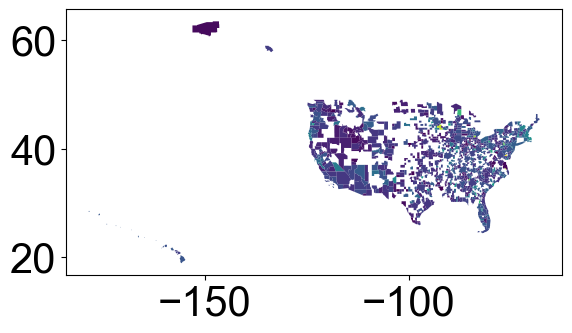

In [44]:

df_count_category = Specialty_Count_cbsa.copy()
# df_count_category[df_count_category['cbsacode']==cb].iloc[0,3:-3]

df_count_category = gpd.GeoDataFrame(df_count_category.merge(cbsa_shape[['cbsacode','geometry']], on='cbsacode'))
df_count_category['INTERNAL MEDICINE_PerCapita'] = df_count_category['INTERNAL MEDICINE']/df_count_category['Population']
df_count_category['ADDICTION MEDICINE_PerCapita'] = df_count_category['ADDICTION MEDICINE']/df_count_category['Population']
df_count_category['UROLOGY_PerCapita'] = df_count_category['UROLOGY']/df_count_category['Population']
df_count_category.plot('INTERNAL MEDICINE_PerCapita')

df_count_category['STUSPS'] = [msa[-2:] for msa in df_count_category.msa_name]

state_shape = gpd.read_file('./tl_2020_us_state/tl_2020_us_state.shp')
state_shape.head()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



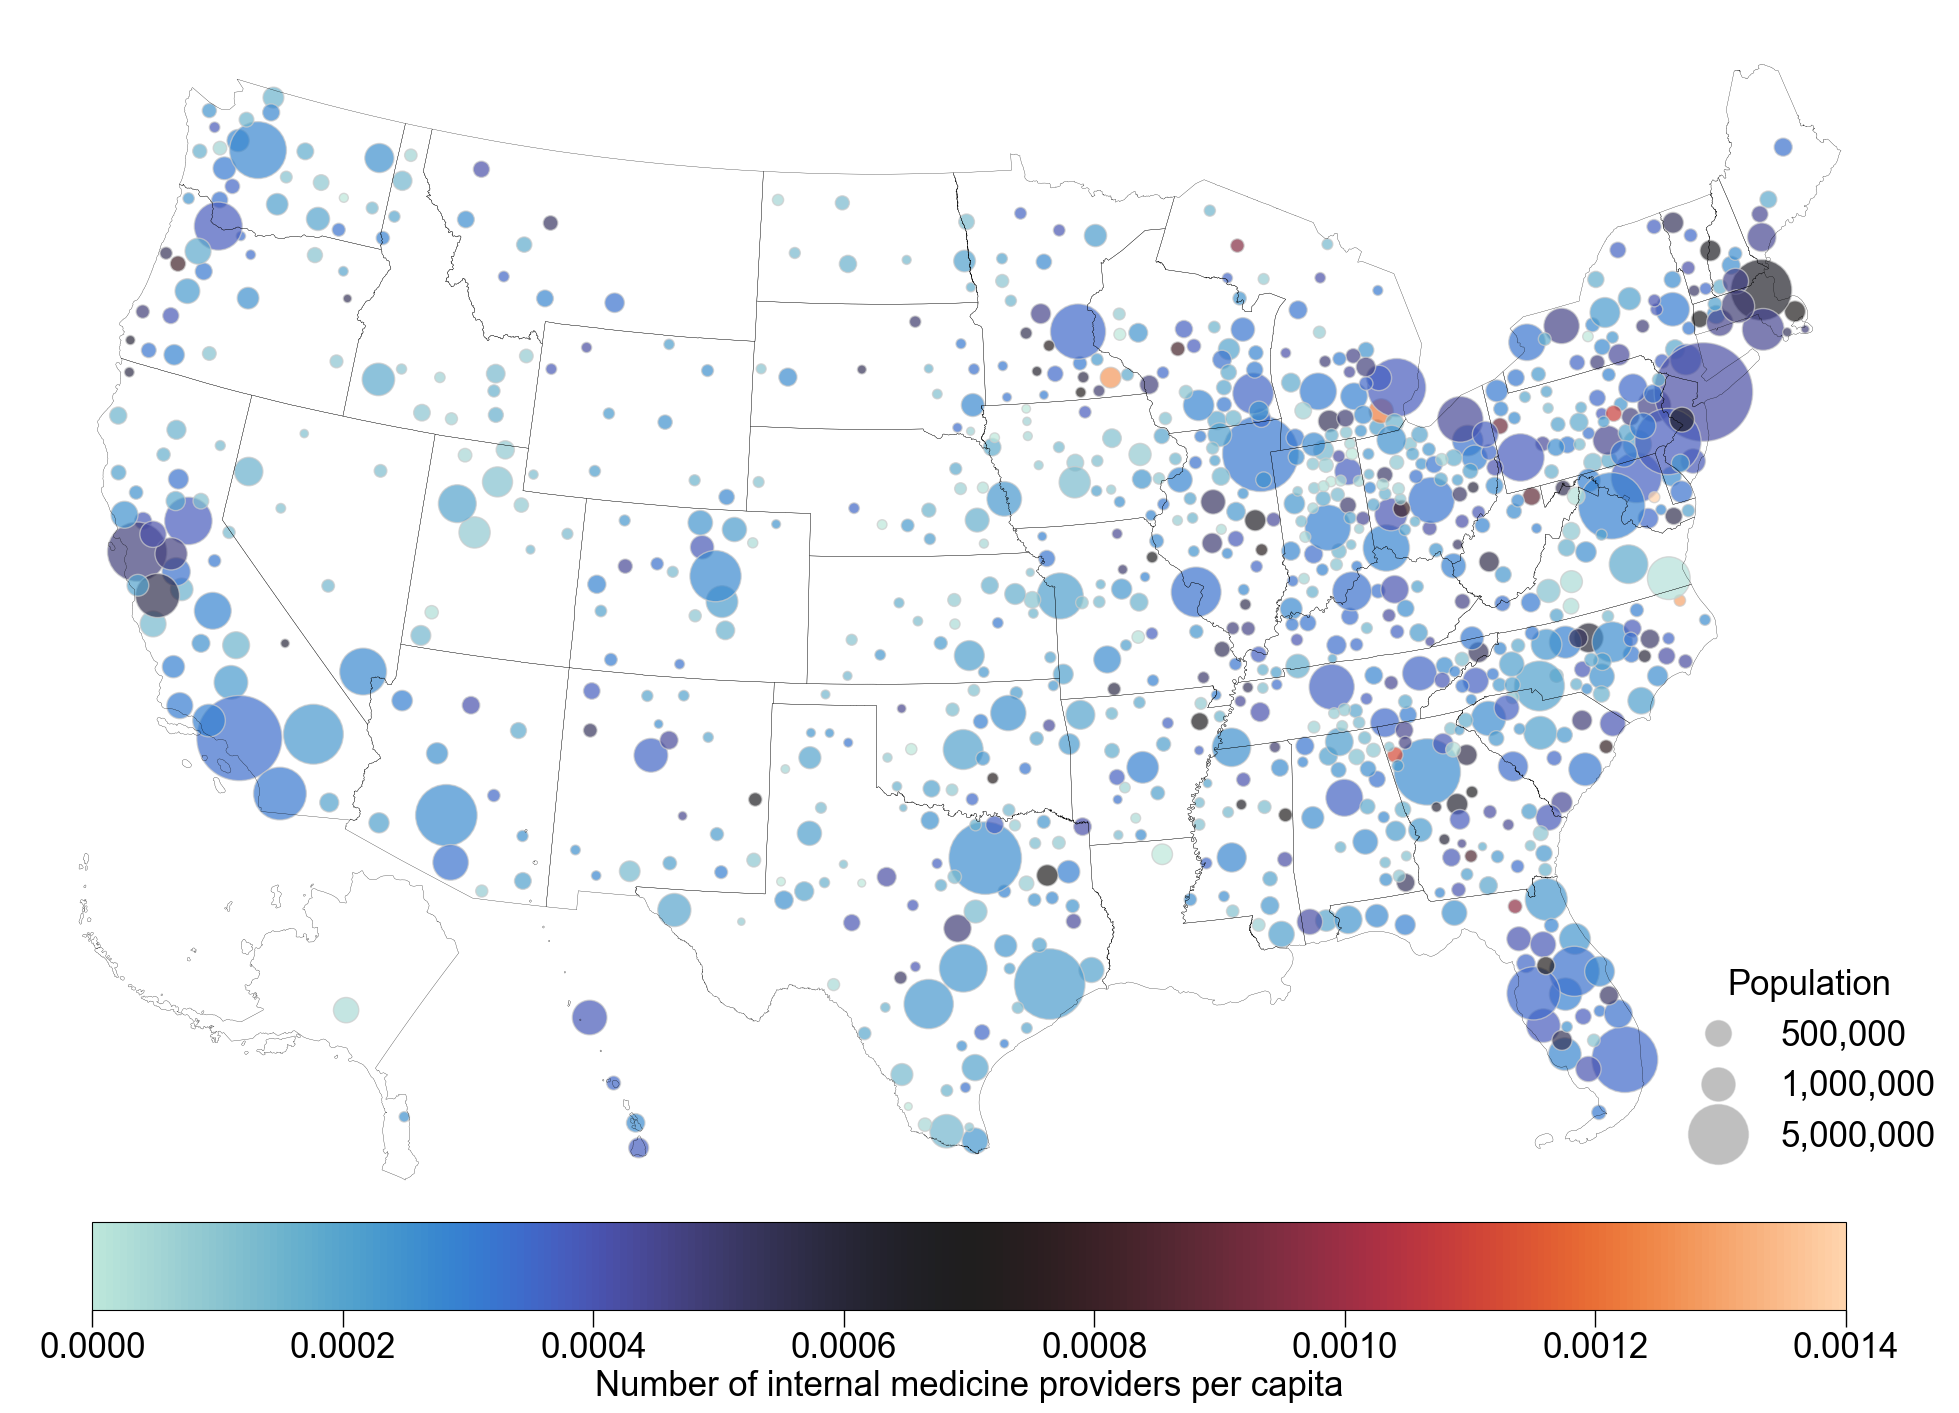

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



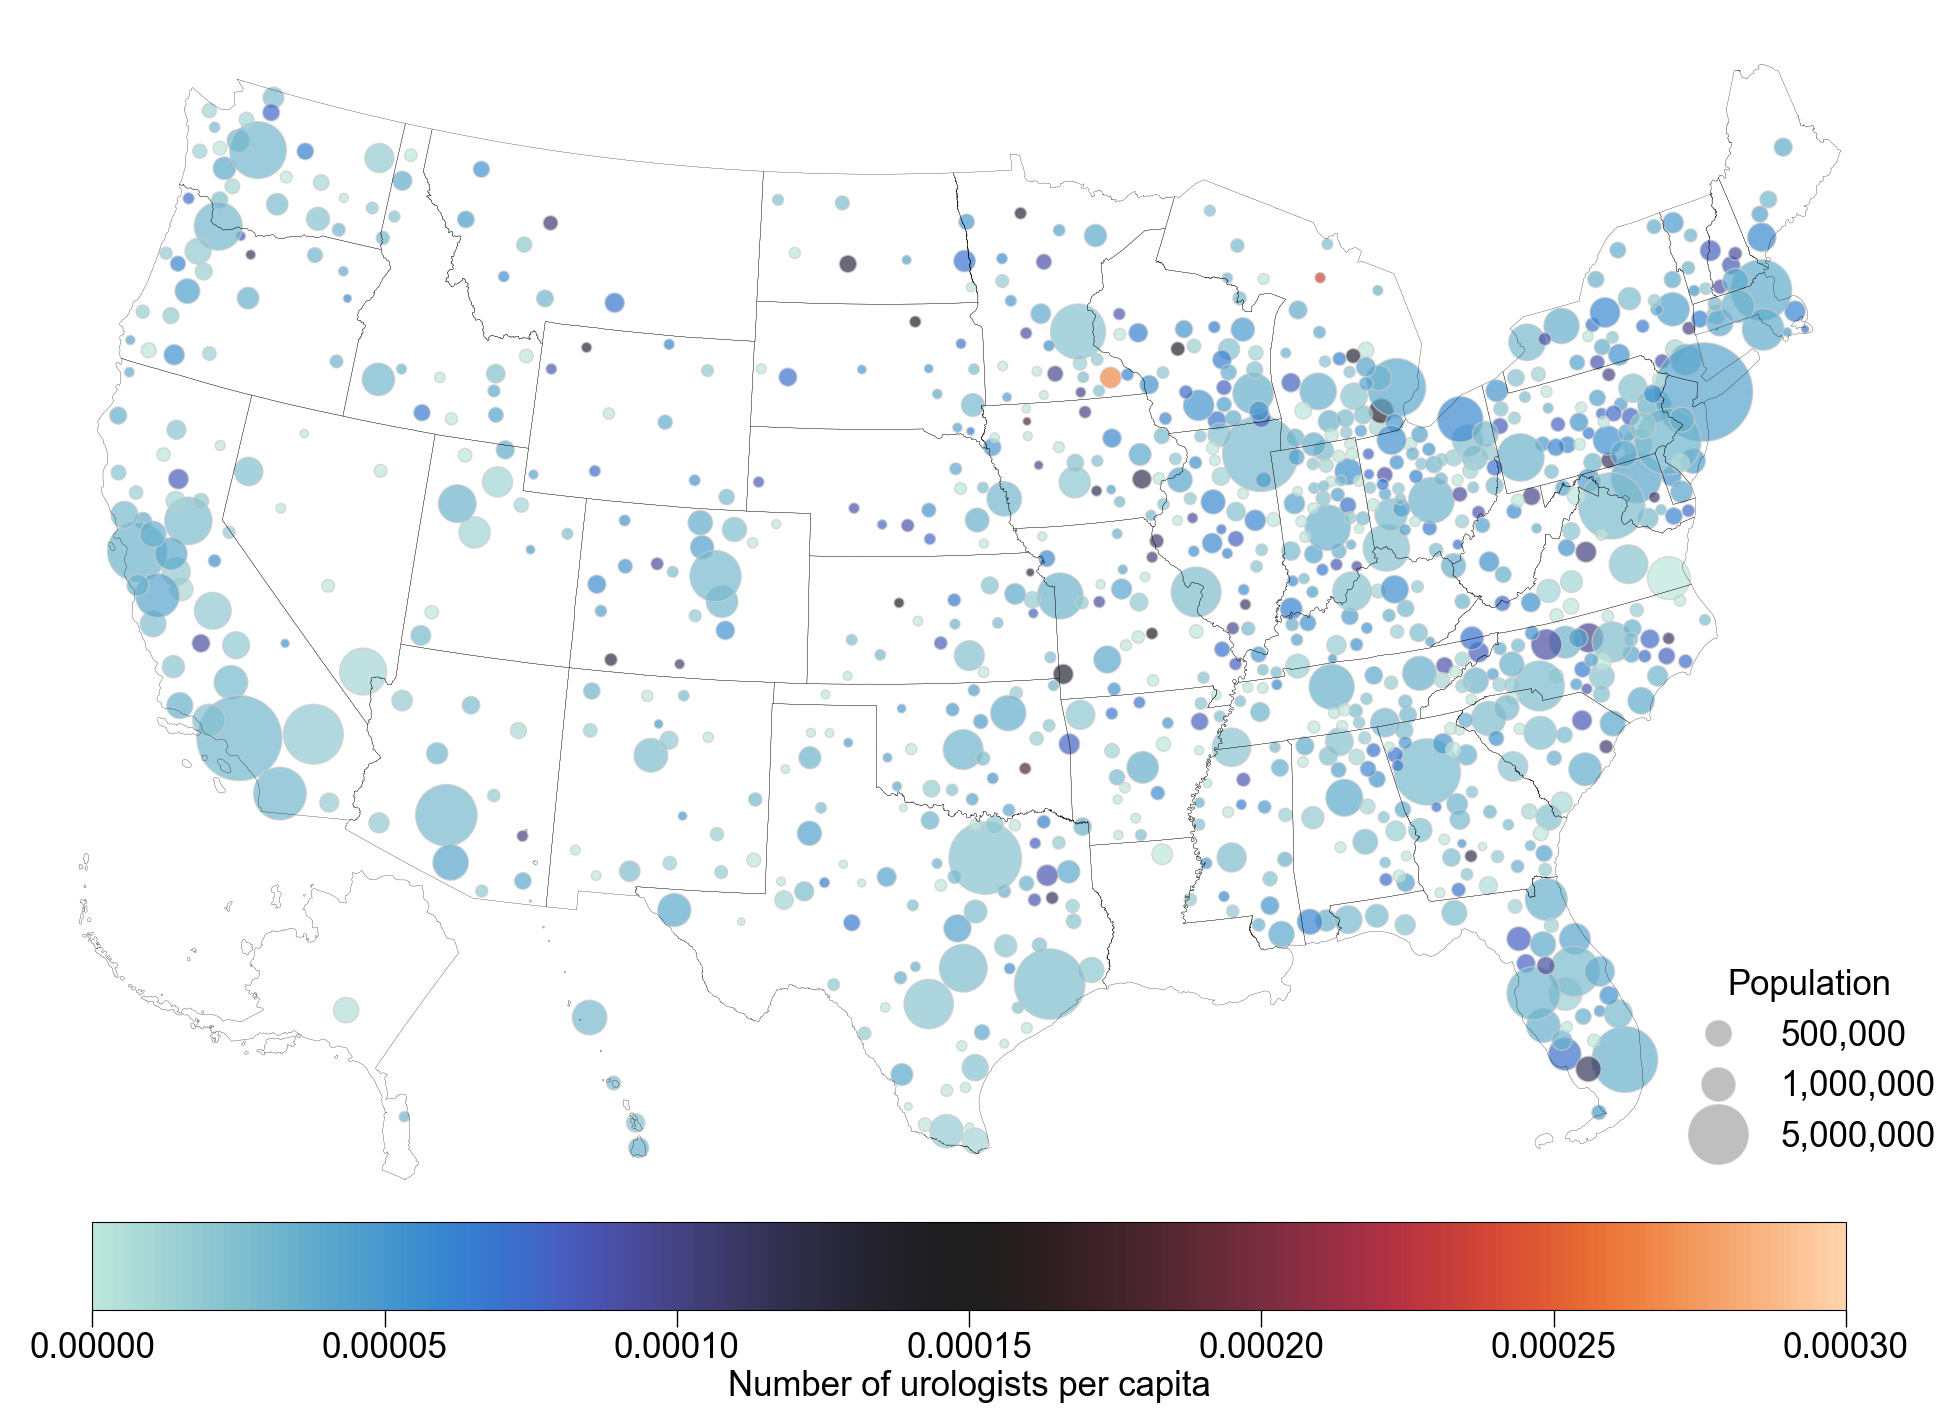

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from shapely.affinity import scale, translate
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker



# --- Settings ---
plt.rcParams.update({
    'font.size': 25,
    'lines.linewidth': 2,
    'font.family': 'arial',
    'mathtext.fontset': 'cm',
    'mathtext.default': 'rm',
    'mathtext.rm': 'arial',
})

# --- CRS Projection ---
df_count_category = df_count_category.to_crs({'init': 'epsg:2163'})
state_shape = state_shape.to_crs({'init': 'epsg:2163'})

# --- Filter states present in data ---
state_shape = state_shape[state_shape['STUSPS'].isin(df_count_category['STUSPS'].unique())]

# --- Define variable and colormap ---
variable = 'INTERNAL MEDICINE_PerCapita'
vmin = 0
vmax = 0.0014
cmap = sns.color_palette("icefire", as_cmap=True)

# --- Separate regions ---
mainland = df_count_category[~df_count_category['STUSPS'].isin(['AK', 'HI'])]
alaska = df_count_category[df_count_category['STUSPS'] == 'AK'].copy()
hawaii = df_count_category[df_count_category['STUSPS'] == 'HI'].copy()

mainland_states = state_shape[~state_shape['STUSPS'].isin(['AK', 'HI'])]
alaska_state = state_shape[state_shape['STUSPS'] == 'AK'].copy()
hawaii_state = state_shape[state_shape['STUSPS'] == 'HI'].copy()

# --- Plot Base Map ---
fig, ax = plt.subplots(figsize=(22, 14), constrained_layout=True)
ax.axis('off')
mainland_states.boundary.plot(ax=ax, color='black', linewidth=0.2)

# --- Generate Point Geometry & Scale ---
df_count_category['centroid'] = df_count_category.geometry.centroid
gdf_points = df_count_category.set_geometry('centroid')

# Normalize population for marker size using square root scaling
size_factor = 1e2
gdf_points['marker_size'] = (gdf_points['Population'] / size_factor)**.7

# --- Plot Mainland Points ---
gdf_points[~gdf_points['STUSPS'].isin(['AK', 'HI'])].plot(
    ax=ax,
    markersize=gdf_points.loc[~gdf_points['STUSPS'].isin(['AK', 'HI']), 'marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8',
    alpha=0.7
)

# --- Alaska Inset ---
alaska.geometry = alaska.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
alaska_state.geometry = alaska_state.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
ak_ax = ax.inset_axes([0.01, 0.01, 0.25, 0.3])
ak_ax.axis('off')
alaska_state.boundary.plot(ax=ak_ax, color='black', linewidth=0.2)
gdf_points_ak = gdf_points[gdf_points['STUSPS'] == 'AK'].copy()
gdf_points_ak.geometry = gdf_points_ak.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
gdf_points_ak.plot(
    ax=ak_ax,
    markersize=gdf_points_ak['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.7
)

# --- Hawaii Inset ---
hawaii.geometry = hawaii.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hawaii_state.geometry = hawaii_state.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hi_ax = ax.inset_axes([0.15, 0.03, 0.3, 0.3])
hi_ax.axis('off')
hawaii_state.boundary.plot(ax=hi_ax, color='black', linewidth=0.2)
gdf_points_hi = gdf_points[gdf_points['STUSPS'] == 'HI'].copy()
gdf_points_hi.geometry = gdf_points_hi.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
gdf_points_hi.plot(
    ax=hi_ax,
    markersize=gdf_points_hi['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.7
)

# --- Colorbar ---
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.8, pad=0.01)
cbar.set_label('Number of internal medicine providers per capita')
cbar.ax.tick_params(labelsize=25, length=12, width=1)

# --- Population Legend ---
legend_pop_sizes = [5e5, 1e6, 5e6]
legend_markers = [(p / size_factor)**.7 for p in legend_pop_sizes]
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'{int(p):,}',
           markerfacecolor='grey',
           markersize=np.sqrt(area),  # Convert area to diameter
           alpha=0.5)
    for p, area in zip(legend_pop_sizes, legend_markers)
]

ax.legend(handles=legend_elements, title='Population',
          loc='lower right', bbox_to_anchor=(1.02, 0.02),
          frameon=False, fontsize=25, title_fontsize=25)

# --- Save ---
# plt.savefig("./IM.pdf", dpi=300, bbox_inches='tight')
plt.show()




################################################

# --- Settings ---
plt.rcParams.update({
    'font.size': 25,
    'lines.linewidth': 2,
    'font.family': 'arial',
    'mathtext.fontset': 'cm',
    'mathtext.default': 'rm',
    'mathtext.rm': 'arial',
})

# --- CRS Projection ---
df_count_category = df_count_category.to_crs({'init': 'epsg:2163'})
state_shape = state_shape.to_crs({'init': 'epsg:2163'})

# --- Filter states present in data ---
state_shape = state_shape[state_shape['STUSPS'].isin(df_count_category['STUSPS'].unique())]

# --- Define variable and colormap ---
variable = 'UROLOGY_PerCapita'
vmin = 0
vmax = 0.0003
cmap = sns.color_palette("icefire", as_cmap=True)

# --- Separate regions ---
mainland = df_count_category[~df_count_category['STUSPS'].isin(['AK', 'HI'])]
alaska = df_count_category[df_count_category['STUSPS'] == 'AK'].copy()
hawaii = df_count_category[df_count_category['STUSPS'] == 'HI'].copy()

mainland_states = state_shape[~state_shape['STUSPS'].isin(['AK', 'HI'])]
alaska_state = state_shape[state_shape['STUSPS'] == 'AK'].copy()
hawaii_state = state_shape[state_shape['STUSPS'] == 'HI'].copy()

# --- Plot Base Map ---
fig, ax = plt.subplots(figsize=(22, 14), constrained_layout=True)
ax.axis('off')
mainland_states.boundary.plot(ax=ax, color='black', linewidth=0.2)

# --- Generate Point Geometry & Scale ---
df_count_category['centroid'] = df_count_category.geometry.centroid
gdf_points = df_count_category.set_geometry('centroid')

# Normalize population for marker size using square root scaling
size_factor = 1e2
gdf_points['marker_size'] = (gdf_points['Population'] / size_factor)**.7

# --- Plot Mainland Points ---
gdf_points[~gdf_points['STUSPS'].isin(['AK', 'HI'])].plot(
    ax=ax,
    markersize=gdf_points.loc[~gdf_points['STUSPS'].isin(['AK', 'HI']), 'marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8',
    alpha=0.7
)

# --- Alaska Inset ---
alaska.geometry = alaska.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
alaska_state.geometry = alaska_state.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
ak_ax = ax.inset_axes([0.01, 0.01, 0.25, 0.3])
ak_ax.axis('off')
alaska_state.boundary.plot(ax=ak_ax, color='black', linewidth=0.2)
gdf_points_ak = gdf_points[gdf_points['STUSPS'] == 'AK'].copy()
gdf_points_ak.geometry = gdf_points_ak.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
gdf_points_ak.plot(
    ax=ak_ax,
    markersize=gdf_points_ak['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.7
)

# --- Hawaii Inset ---
hawaii.geometry = hawaii.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hawaii_state.geometry = hawaii_state.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hi_ax = ax.inset_axes([0.15, 0.03, 0.3, 0.3])
hi_ax.axis('off')
hawaii_state.boundary.plot(ax=hi_ax, color='black', linewidth=0.2)
gdf_points_hi = gdf_points[gdf_points['STUSPS'] == 'HI'].copy()
gdf_points_hi.geometry = gdf_points_hi.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
gdf_points_hi.plot(
    ax=hi_ax,
    markersize=gdf_points_hi['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.7
)

# --- Colorbar ---
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.8, pad=0.01)
cbar.set_label('Number of urologists per capita')
cbar.ax.tick_params(labelsize=25, length=12, width=1)

# --- Population Legend ---
legend_pop_sizes = [5e5, 1e6, 5e6]
legend_markers = [(p / size_factor)**.7 for p in legend_pop_sizes]
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'{int(p):,}',
           markerfacecolor='grey',
           markersize=np.sqrt(area),  # Convert area to diameter
           alpha=0.5)
    for p, area in zip(legend_pop_sizes, legend_markers)
]

ax.legend(handles=legend_elements, title='Population',
          loc='lower right', bbox_to_anchor=(1.02, 0.02),
          frameon=False, fontsize=25, title_fontsize=25)

# --- Save ---
# plt.savefig("./UROLOGY.pdf", dpi=300, bbox_inches='tight')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



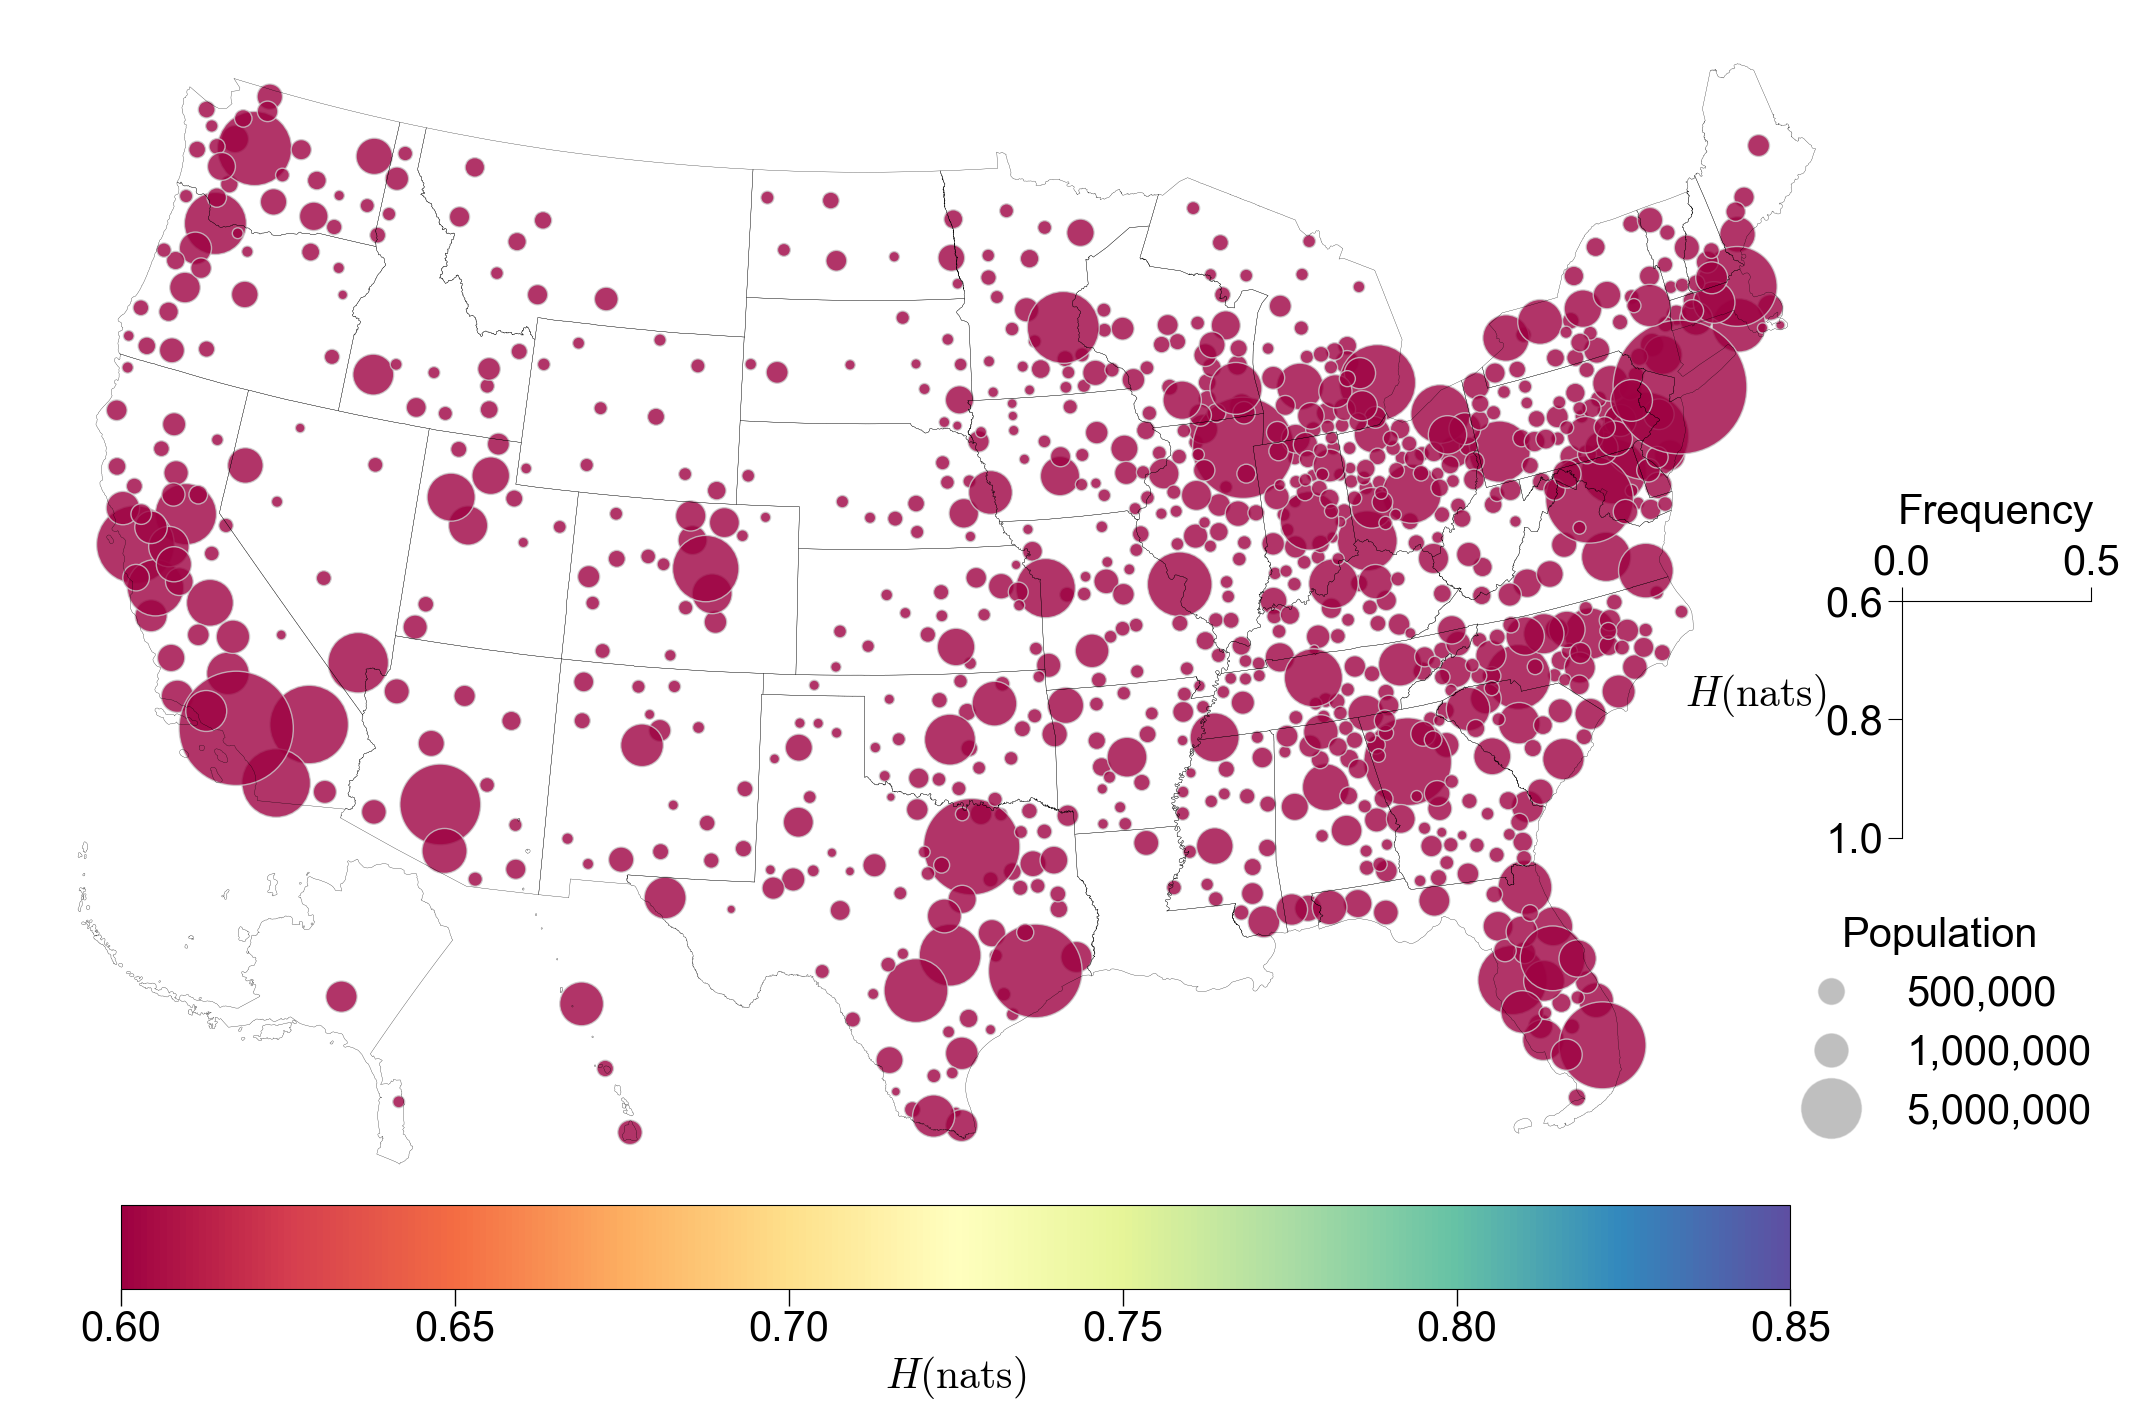

In [ ]:
# df.plot()


import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from shapely.affinity import scale, translate
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# --- Settings ---
plt.rcParams.update({
    'font.size': 30,
    'lines.linewidth': 2,
    'font.family': 'arial',
    'mathtext.fontset': 'cm',
    'mathtext.default': 'it',
    'mathtext.it': 'arial',
})

# --- CRS Projection ---
df_count_category = df_entropy.copy()
df_count_category = df_count_category.to_crs({'init': 'epsg:2163'})
state_shape = state_shape.to_crs({'init': 'epsg:2163'})

# --- Filter states present in data ---
state_shape = state_shape[state_shape['STUSPS'].isin(df_count_category['State'].unique())]

# --- Define variable and colormap ---
variable = 'entropy_diversity_normalized'
# vmin = df_count_category[variable].min()
# vmax = df_count_category[variable].max()
vmin = 0.6; vmax = 0.85
cmap = sns.color_palette("Spectral", as_cmap=True)

# --- Separate regions ---
mainland = df_count_category[~df_count_category['State'].isin(['AK', 'HI'])]
alaska = df_count_category[df_count_category['State'] == 'AK'].copy()
hawaii = df_count_category[df_count_category['State'] == 'HI'].copy()

mainland_states = state_shape[~state_shape['STUSPS'].isin(['AK', 'HI'])]
alaska_state = state_shape[state_shape['STUSPS'] == 'AK'].copy()
hawaii_state = state_shape[state_shape['STUSPS'] == 'HI'].copy()

# --- Plot Base Map ---
fig, ax = plt.subplots(figsize=(22, 14), constrained_layout=True)
ax.axis('off')
mainland_states.boundary.plot(ax=ax, color='black', linewidth=0.2)

# --- Generate Point Geometry & Scale ---
df_count_category['centroid'] = df_count_category.geometry.centroid
gdf_points = df_count_category.set_geometry('centroid')

# Normalize population for marker size using square root scaling
size_factor = 1e2
gdf_points['marker_size'] = (gdf_points['Population'] / size_factor)**.75


# --- Plot Mainland Points ---
gdf_points[~gdf_points['State'].isin(['AK', 'HI'])].plot(
    ax=ax,
    markersize=gdf_points.loc[~gdf_points['State'].isin(['AK', 'HI']), 'marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8',
    alpha=0.8
)

# --- Alaska Inset ---
alaska.geometry = alaska.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
alaska_state.geometry = alaska_state.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
ak_ax = ax.inset_axes([0.01, 0.01, 0.25, 0.3])
ak_ax.axis('off')
alaska_state.boundary.plot(ax=ak_ax, color='black', linewidth=0.2)
gdf_points_ak = gdf_points[gdf_points['State'] == 'AK'].copy()
gdf_points_ak.geometry = gdf_points_ak.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
gdf_points_ak.plot(
    ax=ak_ax,
    markersize=gdf_points_ak['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.8
)

# --- Hawaii Inset ---
hawaii.geometry = hawaii.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hawaii_state.geometry = hawaii_state.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hi_ax = ax.inset_axes([0.15, 0.03, 0.3, 0.3])
hi_ax.axis('off')
hawaii_state.boundary.plot(ax=hi_ax, color='black', linewidth=0.2)
gdf_points_hi = gdf_points[gdf_points['State'] == 'HI'].copy()
gdf_points_hi.geometry = gdf_points_hi.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
gdf_points_hi.plot(
    ax=hi_ax,
    markersize=gdf_points_hi['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.8
)

# --- Colorbar ---
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.8, pad=0.01)
cbar.set_label(r'$H(\mathrm{nats})$')
cbar.ax.tick_params(length=12, width=1)

# --- Population Legend ---
legend_pop_sizes = [5e5, 1e6, 5e6]
legend_markers = [(p / size_factor)**.7 for p in legend_pop_sizes]
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'{int(p):,}',
           markerfacecolor='grey',
           markersize=np.sqrt(area),  # Convert area to diameter
           alpha=0.5)
    for p, area in zip(legend_pop_sizes, legend_markers)
]


# Inset for histogram
ax_inset = ax.inset_axes([1.0, 0.3, 0.1, 0.2], 
                    #   bbox_to_anchor=(0.98, 0.98), bbox_transform=ax.transAxes
                      )

# Histogram data (replace with your actual data)
import seaborn as sns
import numpy as np
sns.histplot(data=df_entropy, y ='entropy_diversity_normalized', bins=10, kde=True, \
             stat="probability",ax=ax_inset,\
              color='#3182bd',
            #   orientation='horizontal'
              )
# sns.histplot(df['entropy_diversity'], bins=20, kde=True,stat="probability", color="#3182bd")


ax_inset.set_ylabel(r"$H(\mathrm{nats})$",rotation=0, labelpad=50)
ax_inset.set_xlabel("Frequency", labelpad=15)
ax_inset.xaxis.set_label_position("top")
ax_inset.xaxis.tick_top()
ax_inset.set_xlim(0,0.5)
ax_inset.set_ylim(1, 0.6)
# ax_inset.set_yticks(size=20)
ax_inset.tick_params(axis='x', length=10,)
ax_inset.tick_params(axis='y', length=10,)

# Remove bottom and right spines
ax_inset.spines['right'].set_visible(False)
ax_inset.spines['bottom'].set_visible(False)

# Remove ticks on bottom and right
ax_inset.tick_params(axis='x', bottom=False)
ax_inset.tick_params(axis='y', right=False)

# Main plot settings
# ax.set_title("City-Level Indicator Map", fontsize=16)


ax.legend(handles=legend_elements, title='Population',
          loc='lower right', bbox_to_anchor=(1.12, 0.02),
          frameon=False,  )

# --- Save ---
# plt.savefig("/Users/tg2426/Documents/Python/DoctorSpecialty/Map_entropy.pdf", dpi=300, bbox_inches='tight')
plt.show()
